## Part 1: Text Preprocessing and Exploration

Let's import the required libraries and load our dataset:

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter

# For text preprocessing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.util import ngrams

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

# For dataset loading
from sklearn.datasets import fetch_20newsgroups

# Set random seed for reproducibility
np.random.seed(42)

# Load a subset of the 20 Newsgroups dataset
categories = ['comp.graphics', 'rec.autos', 'sci.space', 'talk.politics.misc']
newsgroups = fetch_20newsgroups(subset='train', categories=categories, random_state=42)

# Create a DataFrame for easier manipulation
df = pd.DataFrame({
    'text': newsgroups.data,
    'category': [newsgroups.target_names[target] for target in newsgroups.target]
})

# Preview the data
print(f"Dataset shape: {df.shape}")
print("\nCategory distribution:")
print(df['category'].value_counts())
print("\nSample document:")
print(df['text'][10][:500])  # Print first 500 characters of a sample document

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/simranghai/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


Dataset shape: (2236, 2)

Category distribution:
category
rec.autos             594
sci.space             593
comp.graphics         584
talk.politics.misc    465
Name: count, dtype: int64

Sample document:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden


### Step 1: Basic Data Exploration
Let's examine the length characteristics of our documents:

        text_length   word_count  sentence_count
count   2236.000000  2236.000000     2236.000000
mean    1918.330948   291.903846       16.249553
std     3850.168516   584.403700       32.945190
min      125.000000    15.000000        1.000000
25%      744.000000   104.000000        6.000000
50%     1157.500000   173.500000       10.000000
75%     1859.000000   290.000000       16.000000
max    60713.000000  9168.000000      536.000000


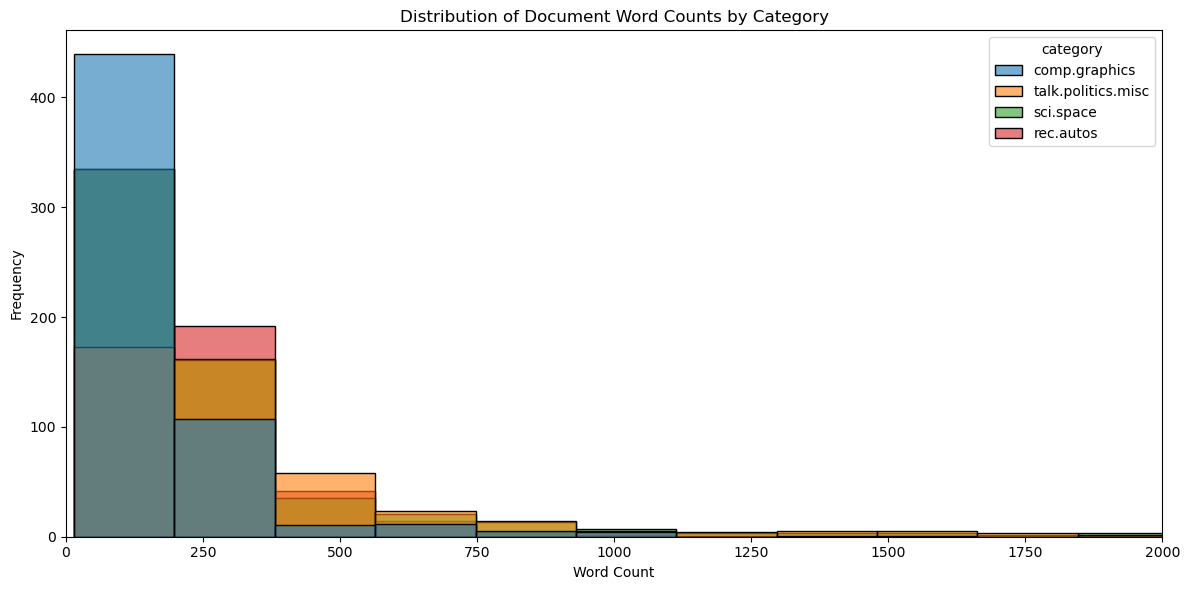

In [2]:
# calculate text length statistics
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))
df['sentence_count'] = df['text'].apply(lambda x: len(sent_tokenize(x)))

#basic stats

print(df[['text_length', 'word_count', 'sentence_count']].describe())

#doc length distribution

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='word_count' , hue='category', bins=50, alpha=0.6)
plt.title( 'Distribution of Document Word Counts by Category')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.xlim(0, 2000)
plt.tight_layout()
plt.show()

### Step 2: Text Cleaning and Preprocessing Function
Let's create a comprehensive text preprocessing function that incorporates all the techniques we've learned:

In [3]:
def preprocess_text(text, remove_stopwords=True, lemmatize=True):
    """
    Comprehensive text preprocessing function.

    parameters:
    text: str
    the input text to preprocess
    remove_stopwrods : bool
    whether to remove stopword
    lemmatize : bool
    whether to apply lemmatization (if Falsse, use stemming instead)

    returns:
    list : list of preprocessed tokens

    """

    # fix empty/non-string input
    if not isinstance(text, str) or text.strip() == '':
        return []

    # lowercasing
    text = text.lower()

    # remove the email headers
    text = re.sub(r'^.*?lines:.*?\n\n', '', text, flags=re.DOTALL)

    # remove urls
    text = re.sub(r'http\S+', '', text)

    # take out special characters/digits
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)

    # tokenization
    tokens = word_tokenize(text)

    # remove stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

    # stemming or lemmatization
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]
    else:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(token) for token in tokens]

    # remove tokens w/less than 3 characters
    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [4]:
# Apply the preprocessing function to the 'text' column
df['processed_text'] = df['text'].apply(preprocess_text)

# Display the first few rows with the new column
print(df[['text', 'processed_text']].head())

                                                text  \
0  From: nfotis@ntua.gr (Nick C. Fotis)\nSubject:...   
1  From: cdm@pmafire.inel.gov (Dale Cook)\nSubjec...   
2  From: rick@trystro.uucp (Richard Nickle)\nSubj...   
3  From: marshatt@feserve.cc.purdue.edu (Zauberer...   
4  From: Clinton-HQ@Campaign92.Org (Clinton/Gore ...   

                                      processed_text  
0  [amanniamunibech, stephan, amann, writes, arti...  
1  [article, aprmagnusacsohiostateedu, rscharfyma...  
2  [article, cljgncscmuedu, mwmcscmuedu, mark, ma...  
3                                                 []  
4  [white, house, office, press, secretary, _____...  


In [5]:
# Function to get the most common tokens for each category
def get_most_common_tokens(dataframe, category_col, text_col, num_tokens=20):
    """
    Gets the most common tokens for each category.

    Parameters:
    dataframe (pd.DataFrame): The input DataFrame.
    category_col (str): The name of the category column.
    text_col (str): The name of the preprocessed text column.
    num_tokens (int): The number of top tokens to retrieve.

    Returns:
    dict: A dictionary where keys are categories and values are lists of
          (token, frequency) tuples.
    """
    common_tokens = {}
    for category in dataframe[category_col].unique():
        category_df = dataframe[dataframe[category_col] == category]
        all_tokens = [token for sublist in category_df[text_col] for token in sublist]
        token_counts = Counter(all_tokens)
        common_tokens[category] = token_counts.most_common(num_tokens)
    return common_tokens

# Get and print the most common tokens for each category
most_common = get_most_common_tokens(df, 'category', 'processed_text')

for category, tokens in most_common.items():
    print(f"\nMost common tokens in '{category}':")
    for token, count in tokens:
        print(f"- {token}: {count}")


Most common tokens in 'comp.graphics':
- image: 724
- file: 523
- graphic: 381
- program: 324
- would: 295
- one: 267
- also: 263
- format: 261
- use: 256
- know: 250
- system: 248
- writes: 245
- color: 237
- article: 234
- jpeg: 230
- software: 228
- bit: 227
- data: 225
- like: 221
- point: 218

Most common tokens in 'talk.politics.misc':
- would: 691
- people: 684
- writes: 611
- article: 573
- one: 514
- dont: 506
- think: 490
- president: 470
- government: 443
- know: 396
- state: 373
- make: 368
- stephanopoulos: 345
- right: 334
- like: 331
- well: 328
- time: 327
- get: 321
- say: 314
- going: 312

Most common tokens in 'sci.space':
- space: 1005
- would: 553
- writes: 452
- one: 413
- article: 397
- nasa: 373
- launch: 367
- year: 340
- like: 327
- system: 316
- satellite: 309
- time: 301
- get: 289
- also: 285
- orbit: 277
- mission: 250
- earth: 249
- dont: 242
- first: 238
- data: 235

Most common tokens in 'rec.autos':
- car: 1168
- writes: 484
- article: 452
- would: 42

### Step 3: Apply Preprocessing and Analyze Results
Now let's apply our preprocessing function to the dataset and examine the results:

In [6]:
# apply preprocessing to sample doc

sample_idx = 10
sample_doc = df['text'][sample_idx]

print("Original document snippet:")
print(sample_doc[:500])

#preprocessing configurations

tokens_basic = preprocess_text(sample_doc, remove_stopwords=False, lemmatize=False)
tokens_nostop = preprocess_text(sample_doc, remove_stopwords=True, lemmatize=False)
tokens_lemmatized = preprocess_text(sample_doc,remove_stopwords = True, lemmatize=True)

print("\nBasic preprocessing (lowercase, no stopword removal, stemming):")
print(tokens_basic[:20])

print("\nWith stopword removal:")
print(tokens_nostop[:20])

print("\nWith Lemmatization:")
print(tokens_lemmatized[:20])


#preprocessing to all the data
df['processed_tokens'] = df['text'].apply(preprocess_text)
df['processed_text'] = df['processed_tokens'].apply(lambda x: ' '.join(x))

#print sample of processed text to see

print("\nSample processed document:")
print(df['processed_text'][sample_idx])


Original document snippet:
From: bob1@cos.com (Bob Blackshaw)
Subject: Re: Dumbest Driver Action
Organization: Corporation for Open Systems
Distribution: usa 
Lines: 41

In <C5Dq2n.5uB@news.cso.uiuc.edu> mwbg9715@uxa.cso.uiuc.edu (Mark Wayne Blunier) writes:

>jimf@centerline.com (Jim Frost) writes:

>>I wish I had the figures with me to back me up, but I recall
>>statistics showing that women tended to have more accidents than men
>>but the damage was generally quite minor.  Men had fewer but far more
>>expensive acciden

Basic preprocessing (lowercase, no stopword removal, stemming):
['cdqnubnewscsouiucedu', 'mwbguxacsouiucedu', 'mark', 'wayn', 'blunier', 'write', 'jimfcenterlinecom', 'jim', 'frost', 'write', 'wish', 'had', 'the', 'figur', 'with', 'back', 'but', 'recal', 'statist', 'show']

With stopword removal:
['cdqnubnewscsouiucedu', 'mwbguxacsouiucedu', 'mark', 'wayn', 'blunier', 'write', 'jimfcenterlinecom', 'jim', 'frost', 'write', 'wish', 'figur', 'back', 'recal', 'statist', 

### Step 4: Token Frequency Analysis
Let's analyze the most common words in each category after preprocessing:

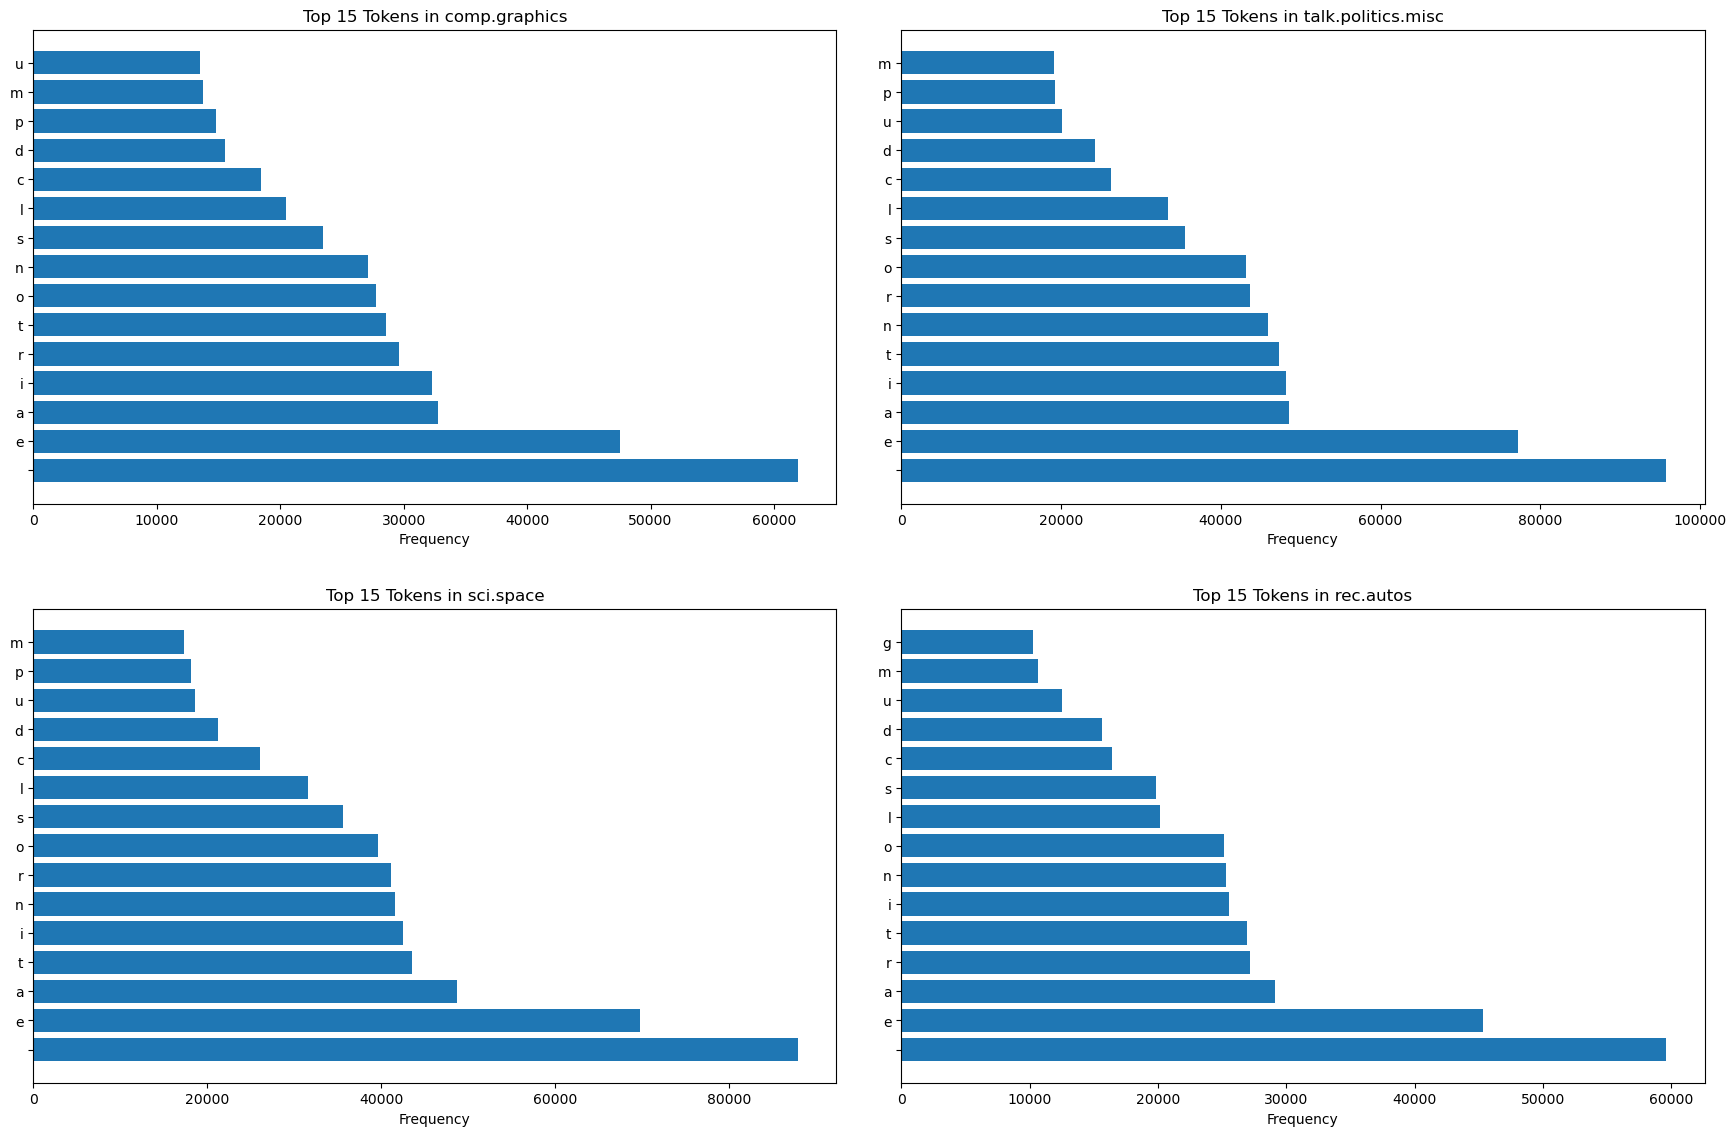

In [7]:
# visualize msot common tokens by category

def plot_top_tokens(dataframe, category_col, tokens_col, n=15):
  """ plot the most common tokens for each category """
  plt.figure(figsize=(18, 12))

  #categorize

  categories= dataframe[category_col].unique()
  num_categories = len(categories)

  #subplots

  for i, category in enumerate(categories, 1):
    plt.subplot(2,2, i)

    #all the tokens for this category

    category_tokens = []
    for tokens in dataframe[dataframe[category_col] == category][tokens_col]:
      category_tokens.extend(tokens)

      #token frequences (count)

    token_counts = Counter(category_tokens).most_common(n)
    tokens, counts = zip(*token_counts)

    #plot

    y_pos = np.arange(len(tokens))
    plt.barh(y_pos, counts, align='center')
    plt.yticks(y_pos, tokens)
    plt.xlabel('Frequency')
    plt.title(f'Top {n} Tokens in {category}')
    plt.tight_layout()

  plt.tight_layout(pad=3.0)
  plt.show()

  #plot top tokens by the categories

plot_top_tokens(df, 'category', 'processed_text', n=15)

### Step 5: N-gram Analysis
Let's go beyond single words and look at common bigrams and trigrams:

In [8]:
# extract n-grams from the tokens

def get_ngrams(tokens, n=2):
  """ extract n-grams from the tokens

  parameters: token_lists = lists of lists
  lists of tokens from where to extract the n-grams
  n: int
  the n in n-gram
  defualt 2 fpr bigrams  """
  all_ngrams = []
  for token_list in tokens: # Changed from 'token_lists' to 'tokens'
    all_ngrams.extend(list(ngrams(token_list, n))) # Changed from 'tokens' to 'token_list'
  return all_ngrams

  #analyze bigrams for each category
for category in df['category'].unique():
  category_tokens = df[df['category'] == category]['processed_tokens']

  bigrams_list = get_ngrams(category_tokens, n=2)

  bigram_counts = Counter(bigrams_list).most_common(10)

  print(f"\nTop 10 bigrams in '{category}':")
  for bigram, count in bigram_counts:
      print(f" {' '.join(bigram)}: {count}")


Top 10 bigrams in 'comp.graphics':
 image processing: 55
 would like: 51
 anyone know: 49
 computer graphic: 47
 dont know: 43
 thanks advance: 43
 file format: 42
 writes article: 38
 source code: 37
 anonymous ftp: 33

Top 10 bigrams in 'talk.politics.misc':
 writes article: 189
 united state: 97
 health care: 97
 dont know: 96
 clayton cramer: 82
 dont think: 66
 white house: 63
 administration official: 53
 senior administration: 51
 steve hendricks: 50

Top 10 bigrams in 'sci.space':
 space station: 80
 writes article: 78
 space shuttle: 65
 henry spencer: 63
 pat writes: 43
 ron baalke: 42
 anyone know: 41
 prbaccessdigexcom pat: 41
 anonymous ftp: 39
 commercial space: 35

Top 10 bigrams in 'rec.autos':
 writes article: 114
 dont know: 41
 send request: 40
 radar detector: 36
 year ago: 36
 new car: 35
 jim frost: 31
 would like: 31
 james callison: 31
 sport car: 30


## Part 2: Time Series Analysis and Modeling

### Step 1: Data Loading and Initial Exploration
First, let's load the S&P 500 historical data and perform initial exploration.

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 12.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 10.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for multitasking: filename=multitasking-0.0.12-py3-none-any.whl size=15548 sha256=b73f418978dbceee1ff9036a576ef783d32b47a887dfdcae6442724438fb56c0
  Stored in directory: /Users/simranghai/Library/Caches/pip/wheels/cc/bd/6f/664d62c99327abeef7d86489e6631cbf45b56fbf7ef1d6ef00
  Created wheel for peewee: filename=peewee-3.18.2-cp312-cp312-macosx_11_0_arm64.whl size=272179 sha256=f424ff939194cfa08ba3594a2f02ae01892216be5bd3c32b540b93f77d0dc1cc
  Stored in directory: /Users/simranghai/Library/Caches/pip/wheels/d1/df/a9/0202b051c65b11c992dd6db9f2babdd2c44ec7d35d511be5d3
Successfully built multitasking peewee
Note: you may need to restart th

[*********************100%***********************]  1 of 1 completed


S&P 500 Dataset:
Price             Close         High          Low         Open      Volume
Ticker            ^GSPC        ^GSPC        ^GSPC        ^GSPC       ^GSPC
Date                                                                      
2013-01-02  1462.420044  1462.430054  1426.189941  1426.189941  4202600000
2013-01-03  1459.369995  1465.469971  1455.530029  1462.420044  3829730000
2013-01-04  1466.469971  1467.939941  1458.989990  1459.369995  3424290000
2013-01-07  1461.890015  1466.469971  1456.619995  1466.469971  3304970000
2013-01-08  1457.150024  1461.890015  1451.640015  1461.890015  3601600000

Dataset information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2013-01-02 to 2022-12-30
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^GSPC)   2518 non-null   float64
 1   (High, ^GSPC)    2518 non-null   float64
 2   (Low, ^GSPC)     2518 non-null   float64
 3   (O

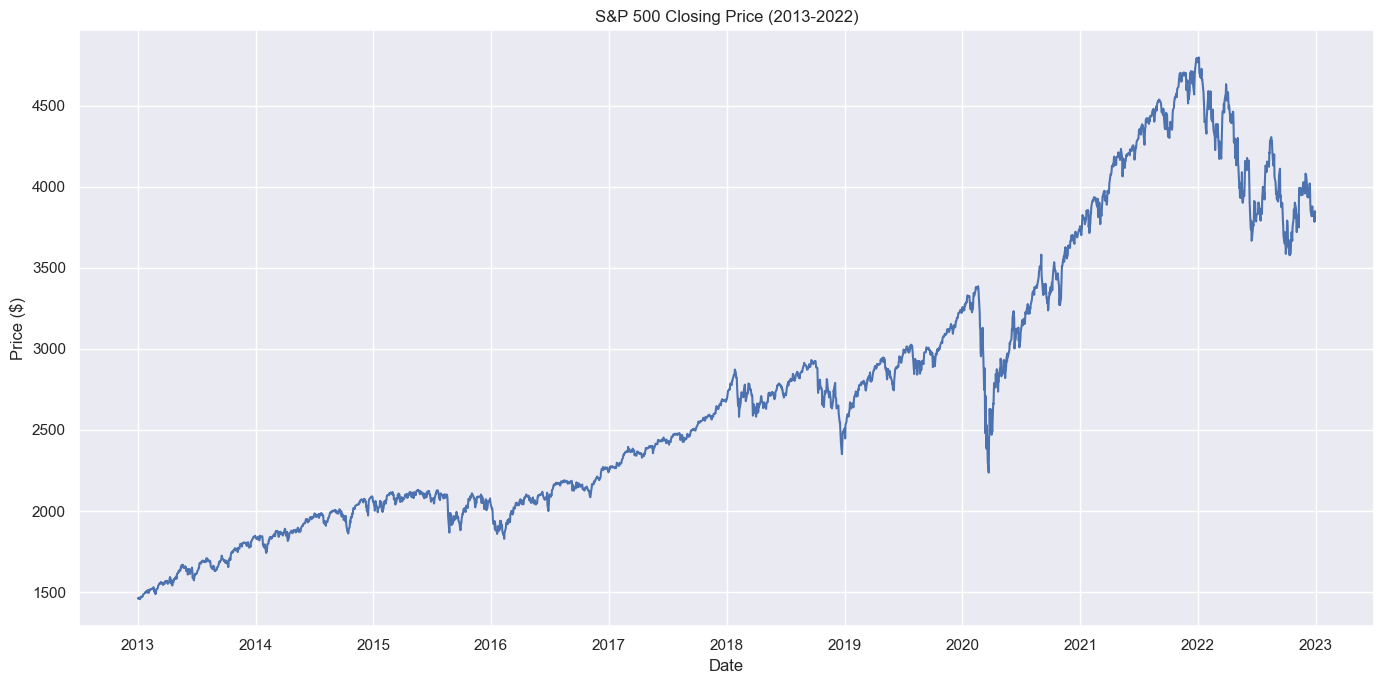


Selected time series shape: (2518, 1)


In [10]:
%pip install yfinance

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Display the first few rows of the dataset
print("S&P 500 Dataset:")
print(sp500.head())

# Display basic information about the dataset
print("\nDataset information:")
print(sp500.info())

# Calculate basic summary statistics
print("\nSummary Statistics:")
print(sp500['Close'].describe())

# Check for missing values
print("\nMissing values in each column:")
print(sp500.isnull().sum())

# Plot the closing price
plt.figure(figsize=(14, 7))
plt.plot(sp500.index, sp500['Close'])
plt.title('S&P 500 Closing Price (2013-2022)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']
print("\nSelected time series shape:", ts_data.shape)

### Step 2: Time Series Characteristics and Visualization
Let's analyze the characteristics of the time series through various visualizations.

[*********************100%***********************]  1 of 1 completed


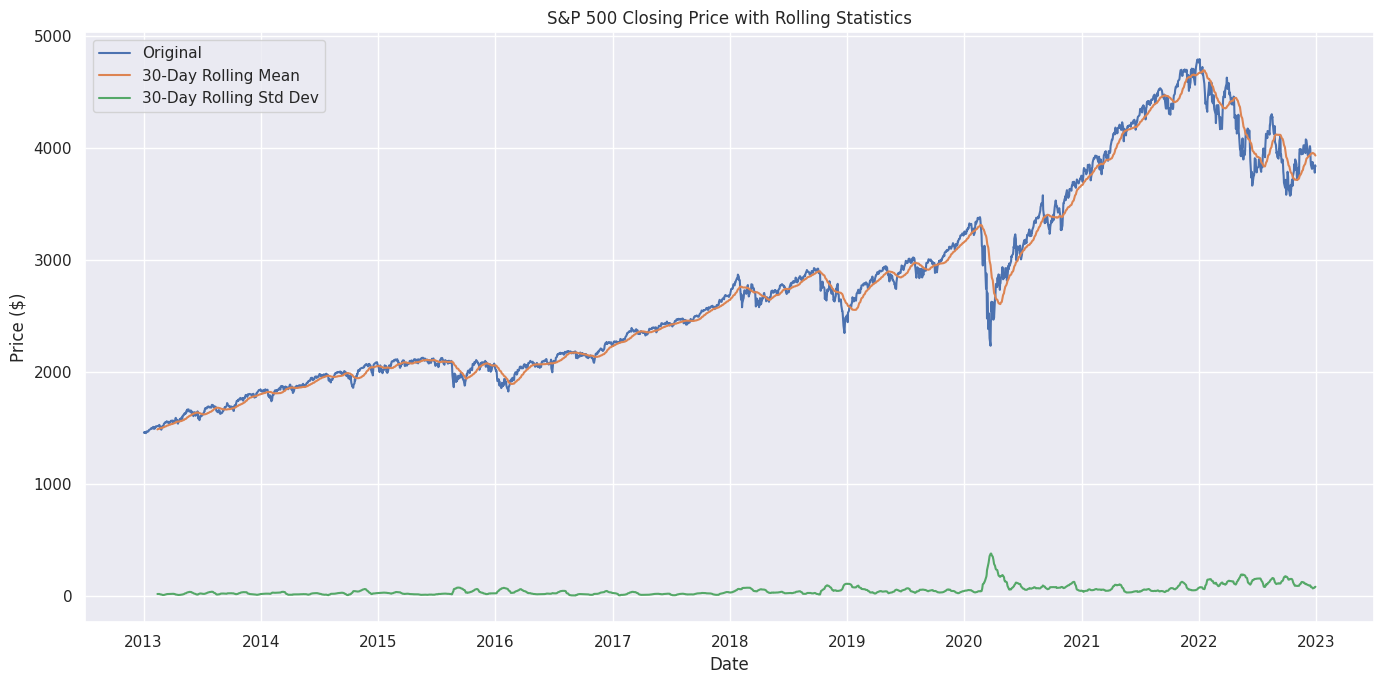

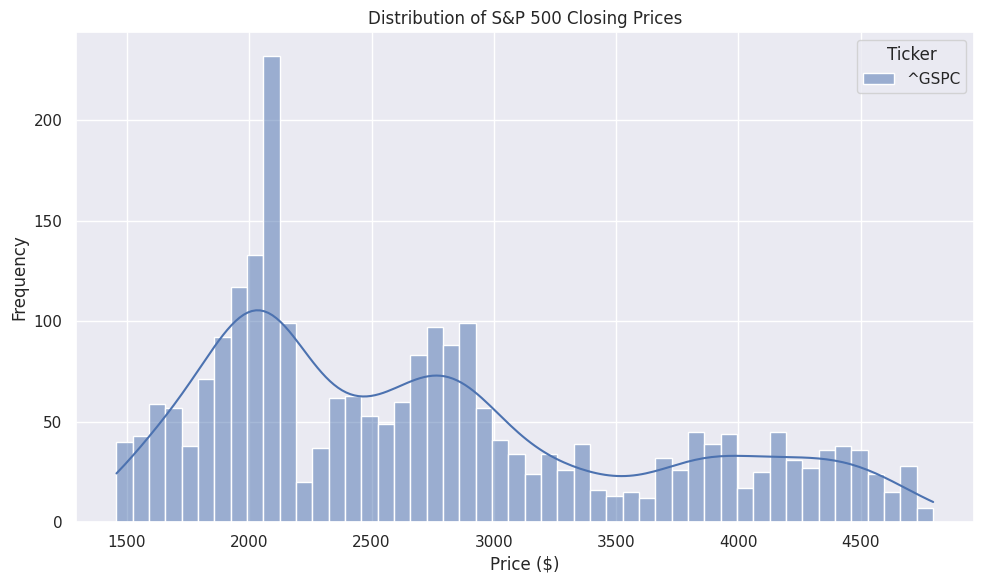

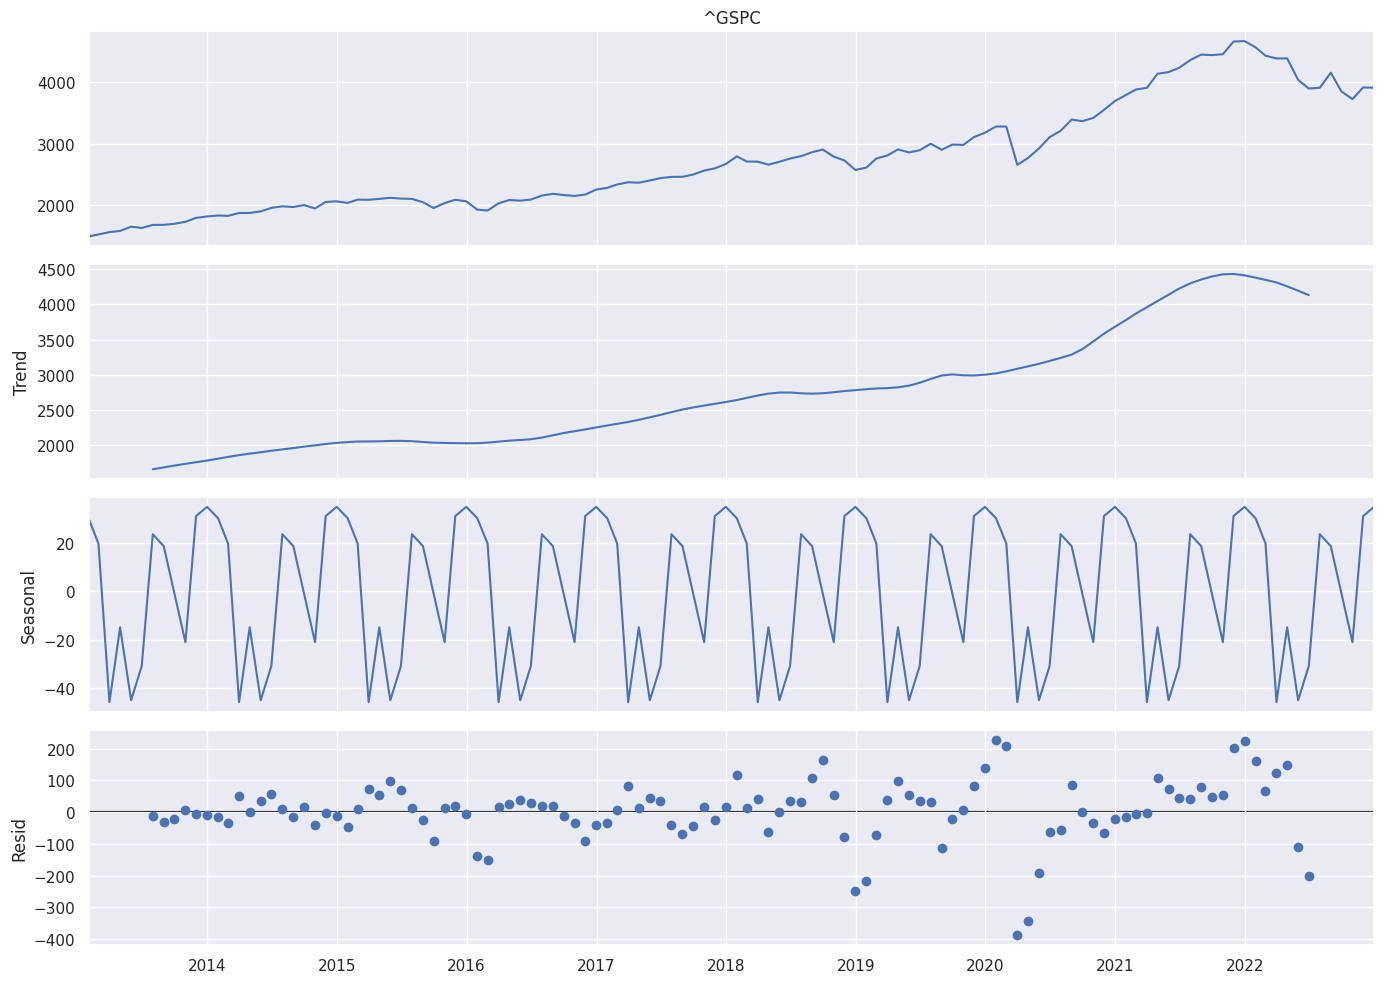

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']

# Plotting the original time series with rolling statistics
plt.figure(figsize=(14, 7))
plt.plot(ts_data, label='Original')
plt.plot(ts_data.rolling(window=30).mean(), label='30-Day Rolling Mean')
plt.plot(ts_data.rolling(window=30).std(), label='30-Day Rolling Std Dev')
plt.title('S&P 500 Closing Price with Rolling Statistics')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotting the distribution of the time series data
plt.figure(figsize=(10, 6))
sns.histplot(ts_data, bins=50, kde=True)
plt.title('Distribution of S&P 500 Closing Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Performing seasonal decomposition (using monthly data for clearer seasonality)
# Resample to monthly frequency for decomposition
monthly_ts = ts_data.resample('M').mean()
# Convert monthly_ts DataFrame to a Series by selecting the column
monthly_ts_series = monthly_ts.iloc[:, 0]
decomposition = seasonal_decompose(monthly_ts_series, model='additive', period=12) # Added period=12

# Plotting the decomposed components
fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.tight_layout()
plt.show()

### Step 3: Stationarity Testing and Transformation
Now, let's test for stationarity using the Dickey-Fuller test and apply transformations to make the data stationary.

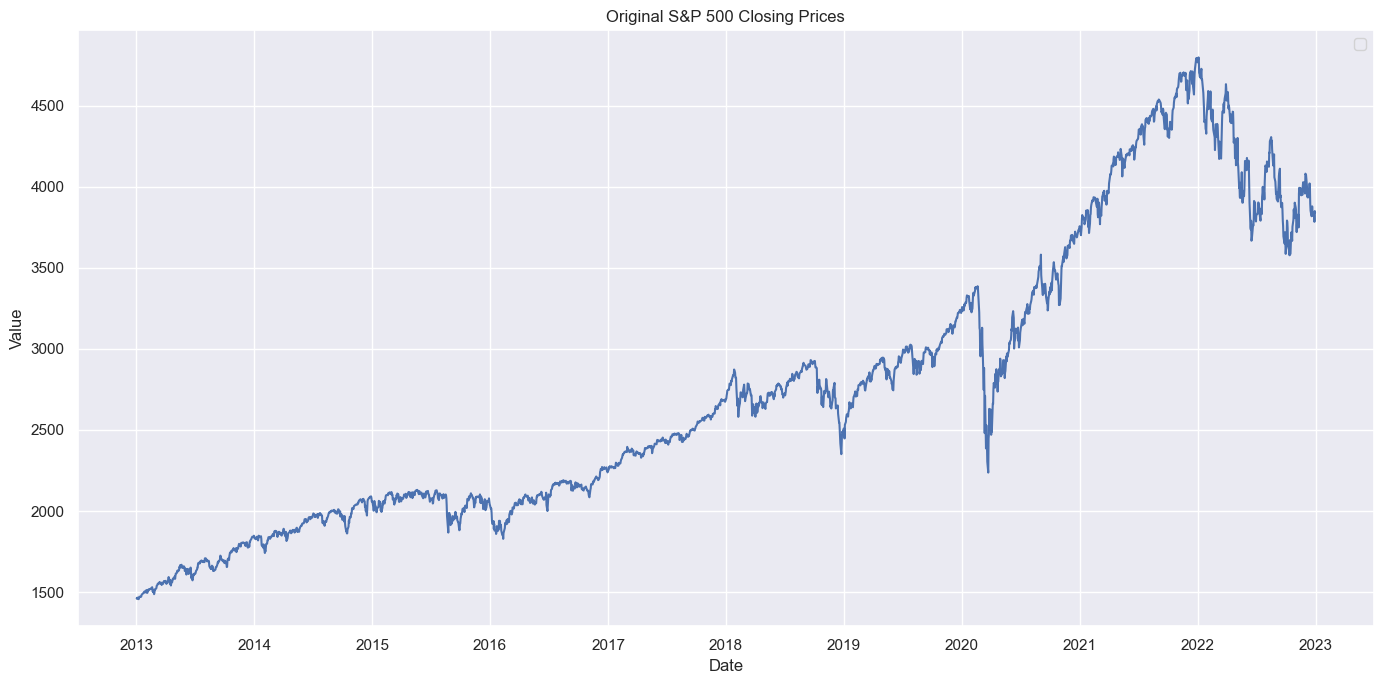

Results of Dickey-Fuller test for Original S&P 500 Closing Prices:
Test Statistic                   -1.031209
p-value                           0.741712
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
The series is non-stationary


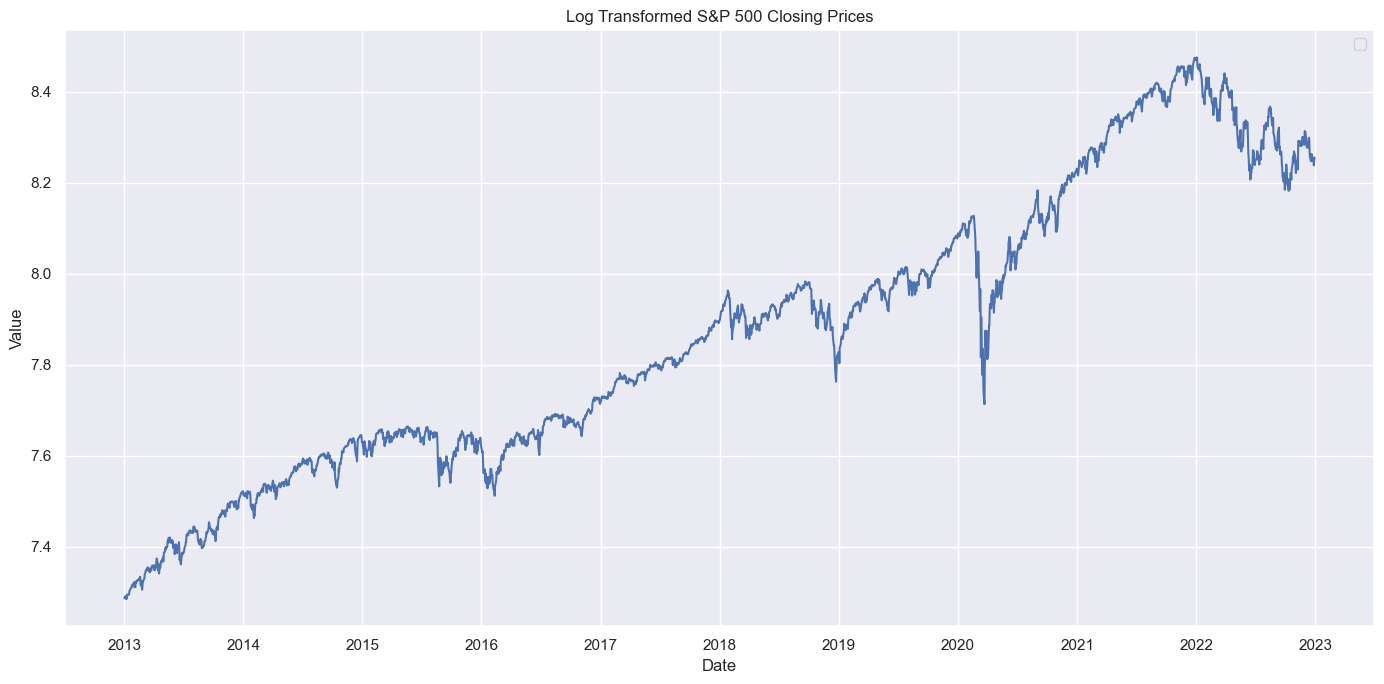

Results of Dickey-Fuller test for Log Transformed S&P 500 Closing Prices:
Test Statistic                   -1.411355
p-value                           0.576820
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
The series is non-stationary


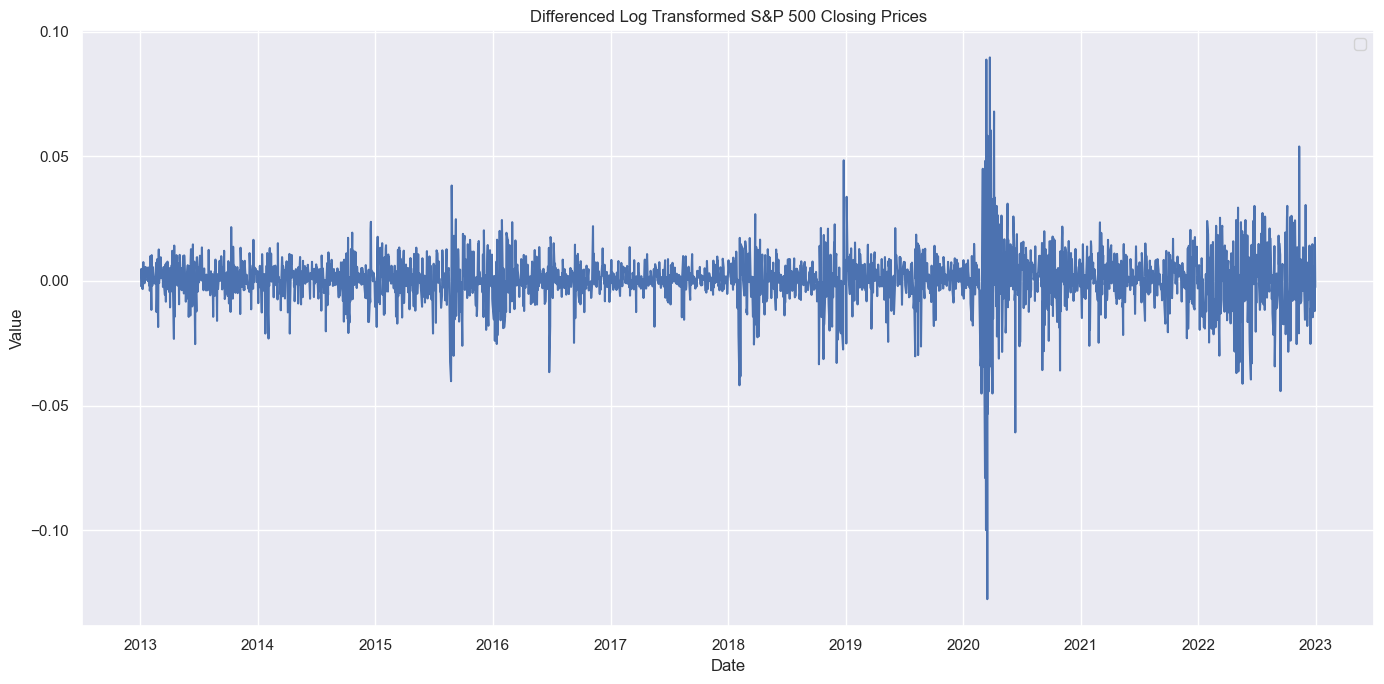

Results of Dickey-Fuller test for Differenced Log Transformed S&P 500 Closing Prices:
Test Statistic                -1.583739e+01
p-value                        9.782659e-29
#Lags Used                     9.000000e+00
Number of Observations Used    2.507000e+03
Critical Value (1%)           -3.432961e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567384e+00
dtype: float64
The series is stationary
Final Transformed data (first 5 values): 
Ticker         ^GSPC
Date                
2013-01-03 -0.002088
2013-01-04  0.004853
2013-01-07 -0.003128
2013-01-08 -0.003248
2013-01-09  0.002652


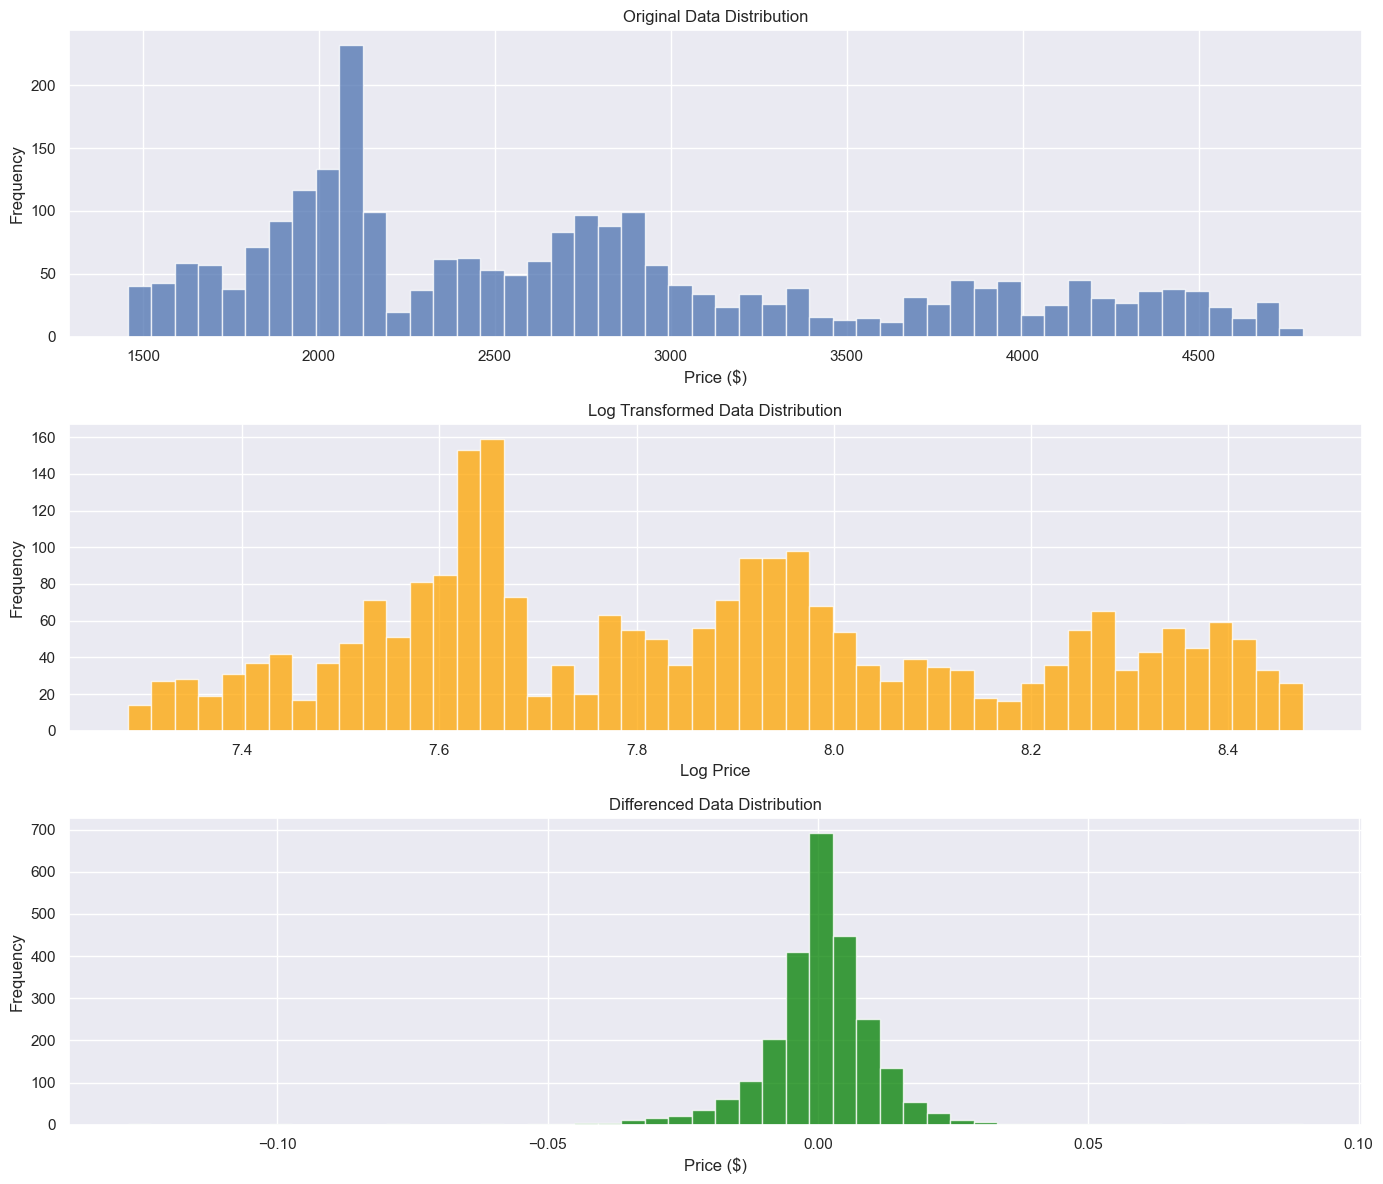

In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title):
    """
    Test for stationarity using the Dickey-Fuller test and plot the time series.

    Parameters:
    timeseries (pd.Series): The time series data.
    title (str): The title for the plot and test results.
    """
    # Plot the time series
    plt.figure(figsize=(14, 7))
    plt.plot(timeseries)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Dickey-Fuller test
    print(f'Results of Dickey-Fuller test for {title}:')
    dftest = adfuller(timeseries.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    # Test results for Dickey-Fuller test
    if dftest[1] <= 0.05:
        print('The series is stationary')
    else:
        print('The series is non-stationary')

# test stationary on og time series
test_stationarity(ts_data, 'Original S&P 500 Closing Prices')

#log transformation
ts_log = np.log(ts_data)

test_stationarity(ts_log, 'Log Transformed S&P 500 Closing Prices')

#first order differencing
ts_log_diff = ts_log.diff().dropna()

test_stationarity(ts_log_diff, 'Differenced Log Transformed S&P 500 Closing Prices')

#verify final data
print("Final Transformed data (first 5 values): ")
print(ts_log_diff.head())

#histograms for comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

#og data distribution
axes[0].hist(ts_data, bins=50, alpha=0.75)
axes[0].set_title('Original Data Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Log transformed data distribution
axes[1].hist(ts_log, bins=50, alpha=0.75, color='orange')
axes[1].set_title('Log Transformed Data Distribution')
axes[1].set_xlabel('Log Price')
axes[1].set_ylabel('Frequency')

axes[2].hist(ts_log_diff, bins=50, alpha=0.75, color= 'green')
axes[2].set_title('Differenced Data Distribution')
axes[2].set_xlabel('Price ($)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Step 4: Time Series Decomposition
Let's decompose our time series into trend, seasonal, and residual components.

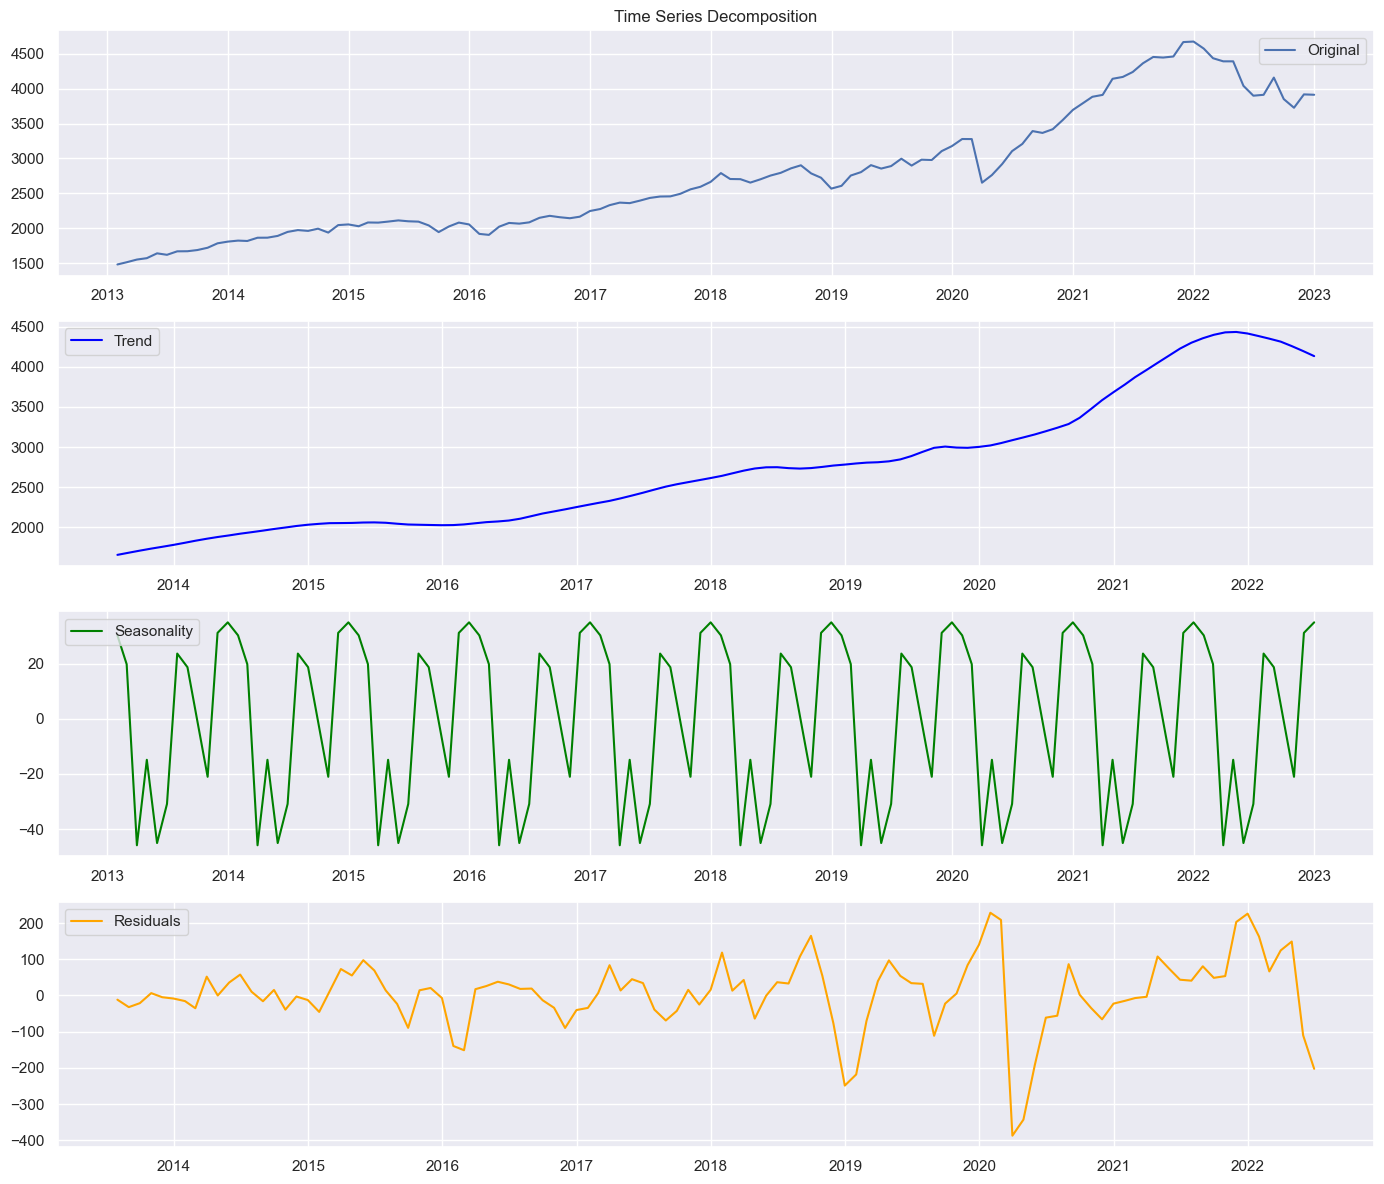

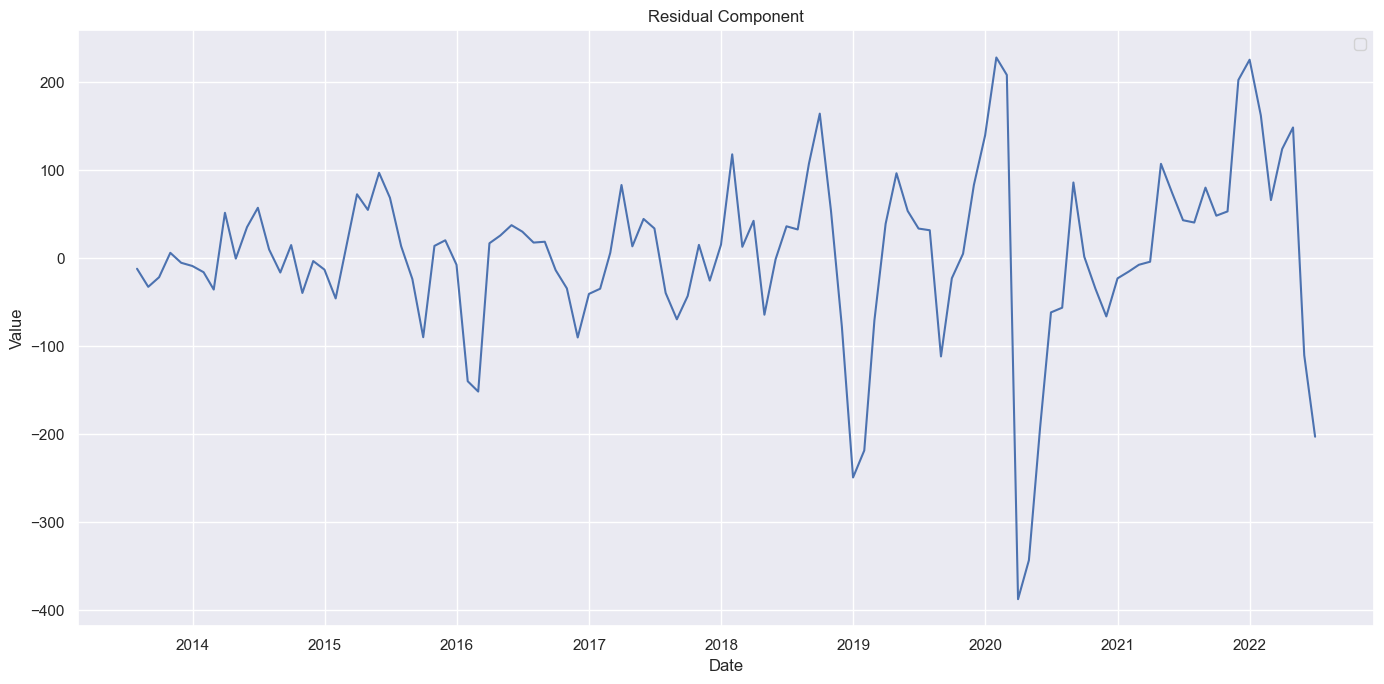

Results of Dickey-Fuller test for Residual Component:
Test Statistic                -6.594910e+00
p-value                        6.964602e-09
#Lags Used                     1.000000e+00
Number of Observations Used    1.060000e+02
Critical Value (1%)           -3.493602e+00
Critical Value (5%)           -2.889217e+00
Critical Value (10%)          -2.581533e+00
dtype: float64
The series is stationary
                                                Mean  \
Original  Ticker
^GSPC    2741.813346
dtype: float64   
Trend                                     2737.76421   
Seasonal                                         0.0   
Residual                                    4.532221   

                                                Std  \
Original  Ticker
^GSPC    873.994953
dtype: float64   
Trend                                    811.008743   
Seasonal                                  29.219642   
Residual                                  98.125801   

                                         

In [12]:
#resample data to monthly freq

monthly_ts = ts_data.resample('M').mean()

#decompose time

decomposition = seasonal_decompose(monthly_ts, model='additive', period=12)

#plot decomposition

plt.figure(figsize=(14, 12))

#og

plt.subplot(411)
plt.plot(monthly_ts, label='Original')
plt.legend(loc='best')
plt.title('Time Series Decomposition')

#trend
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color ='blue')
plt.legend(loc='best')

#seasonal
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonality', color = 'green')
plt.legend(loc='best')

#residuals
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color = 'orange')
plt.legend(loc='best')

plt.tight_layout()
plt.show()

#components for analysis

trend = decomposition.trend
seasonal= decomposition.seasonal
residual = decomposition.resid

#stationarity of residual

residual_dropna = residual.dropna()
test_stationarity(residual_dropna, 'Residual Component')

#properties of each component

components = {
    'Original': monthly_ts,
    'Trend': trend,
    'Seasonal': seasonal,
    'Residual': residual_dropna
}

#summary table

summary = pd.DataFrame({
    'Mean': [component.mean() for name, component in components.items()],
    'Std': [component.std() for name, component in components.items()],
    'Min': [component.min() for name, component in components.items()],
    'Max': [component.max() for name, component in components.items()]
}, index=components.keys())

print(summary)

### Step 5: Autocorrelation Analysis
Now, let's analyze the autocorrelation structure of our stationary series.

[*********************100%***********************]  1 of 1 completed


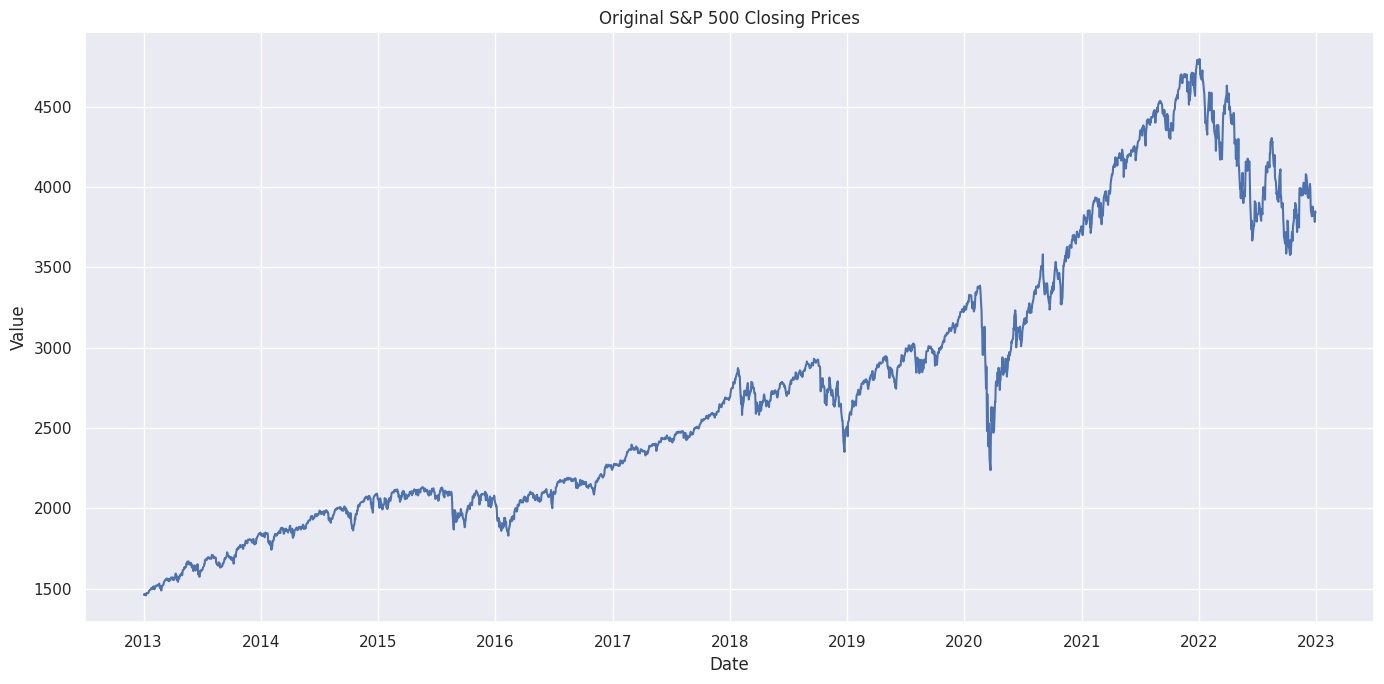

Results of Dickey-Fuller test for Original S&P 500 Closing Prices:
Test Statistic                   -1.031209
p-value                           0.741712
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
The series is non-stationary


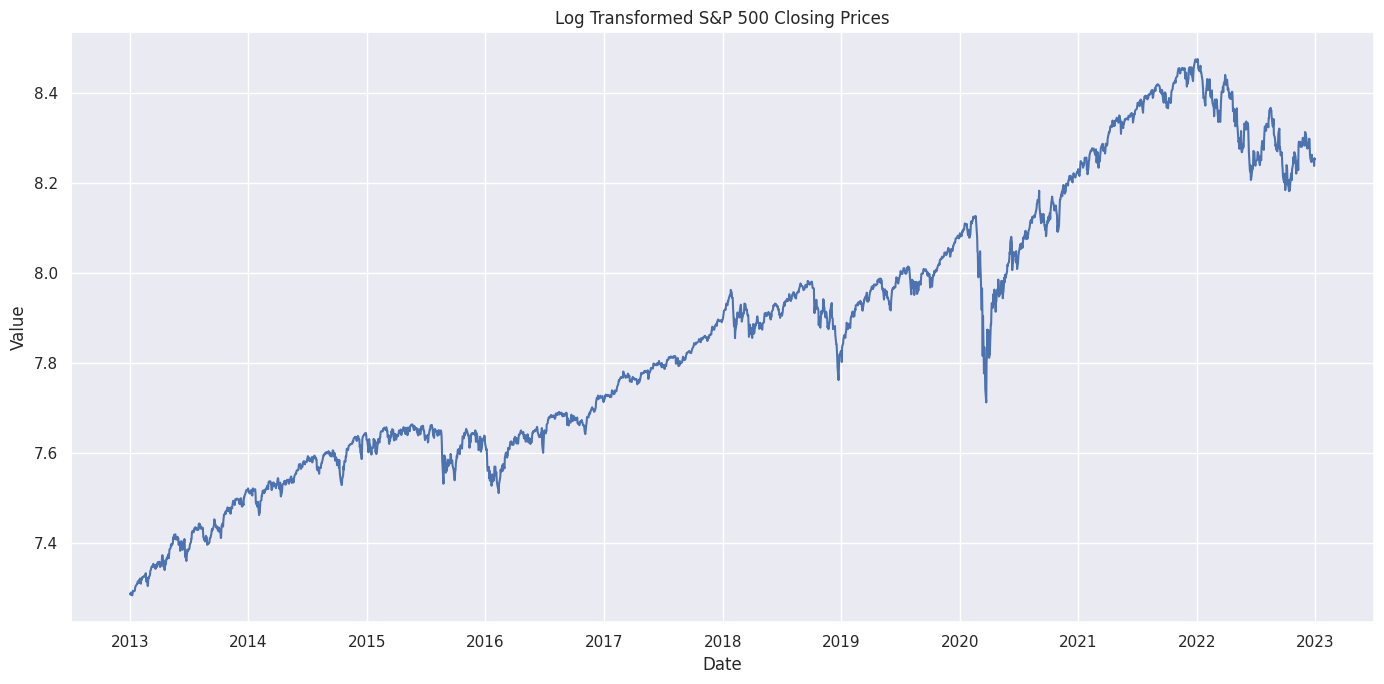

Results of Dickey-Fuller test for Log Transformed S&P 500 Closing Prices:
Test Statistic                   -1.411355
p-value                           0.576820
#Lags Used                       10.000000
Number of Observations Used    2507.000000
Critical Value (1%)              -3.432961
Critical Value (5%)              -2.862694
Critical Value (10%)             -2.567384
dtype: float64
The series is non-stationary


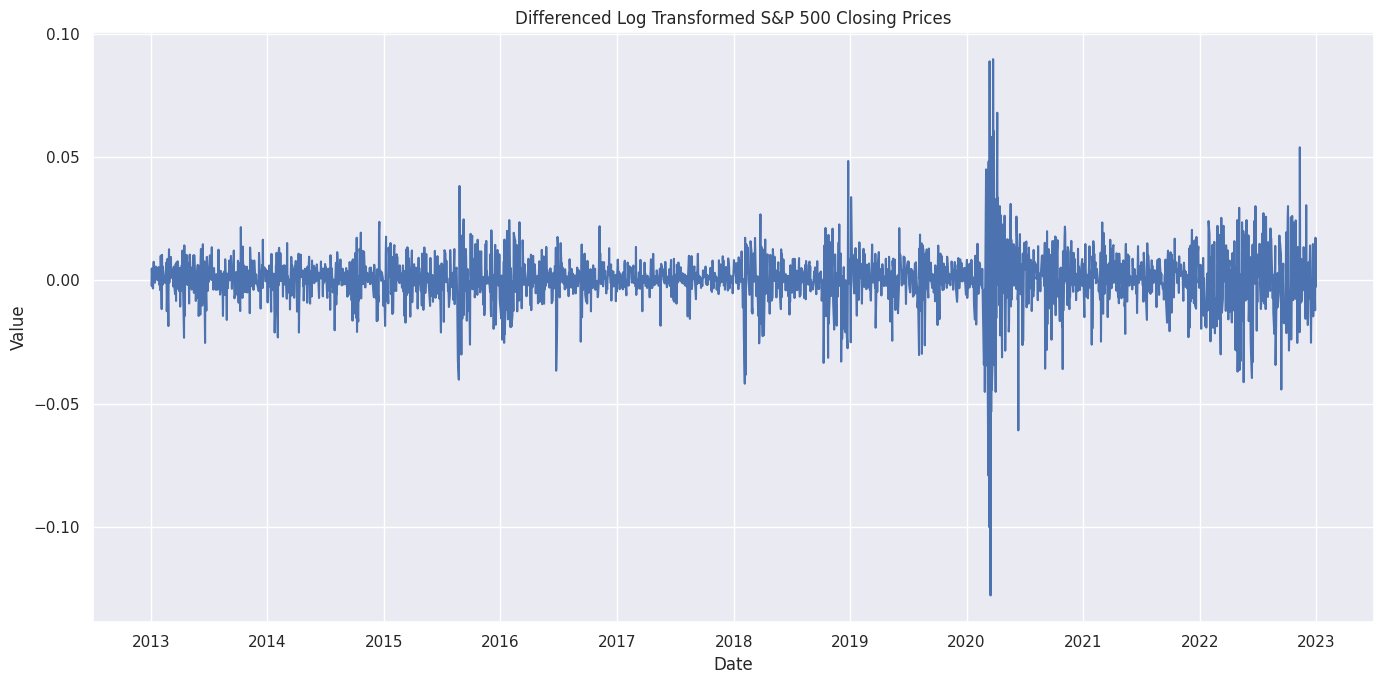

Results of Dickey-Fuller test for Differenced Log Transformed S&P 500 Closing Prices:
Test Statistic                -1.583739e+01
p-value                        9.782659e-29
#Lags Used                     9.000000e+00
Number of Observations Used    2.507000e+03
Critical Value (1%)           -3.432961e+00
Critical Value (5%)           -2.862694e+00
Critical Value (10%)          -2.567384e+00
dtype: float64
The series is stationary
Final Transformed data (first 5 values): 
Date
2013-01-03   -0.002088
2013-01-04    0.004853
2013-01-07   -0.003128
2013-01-08   -0.003248
2013-01-09    0.002652
Name: Differenced Log S&P 500 Close, dtype: float64


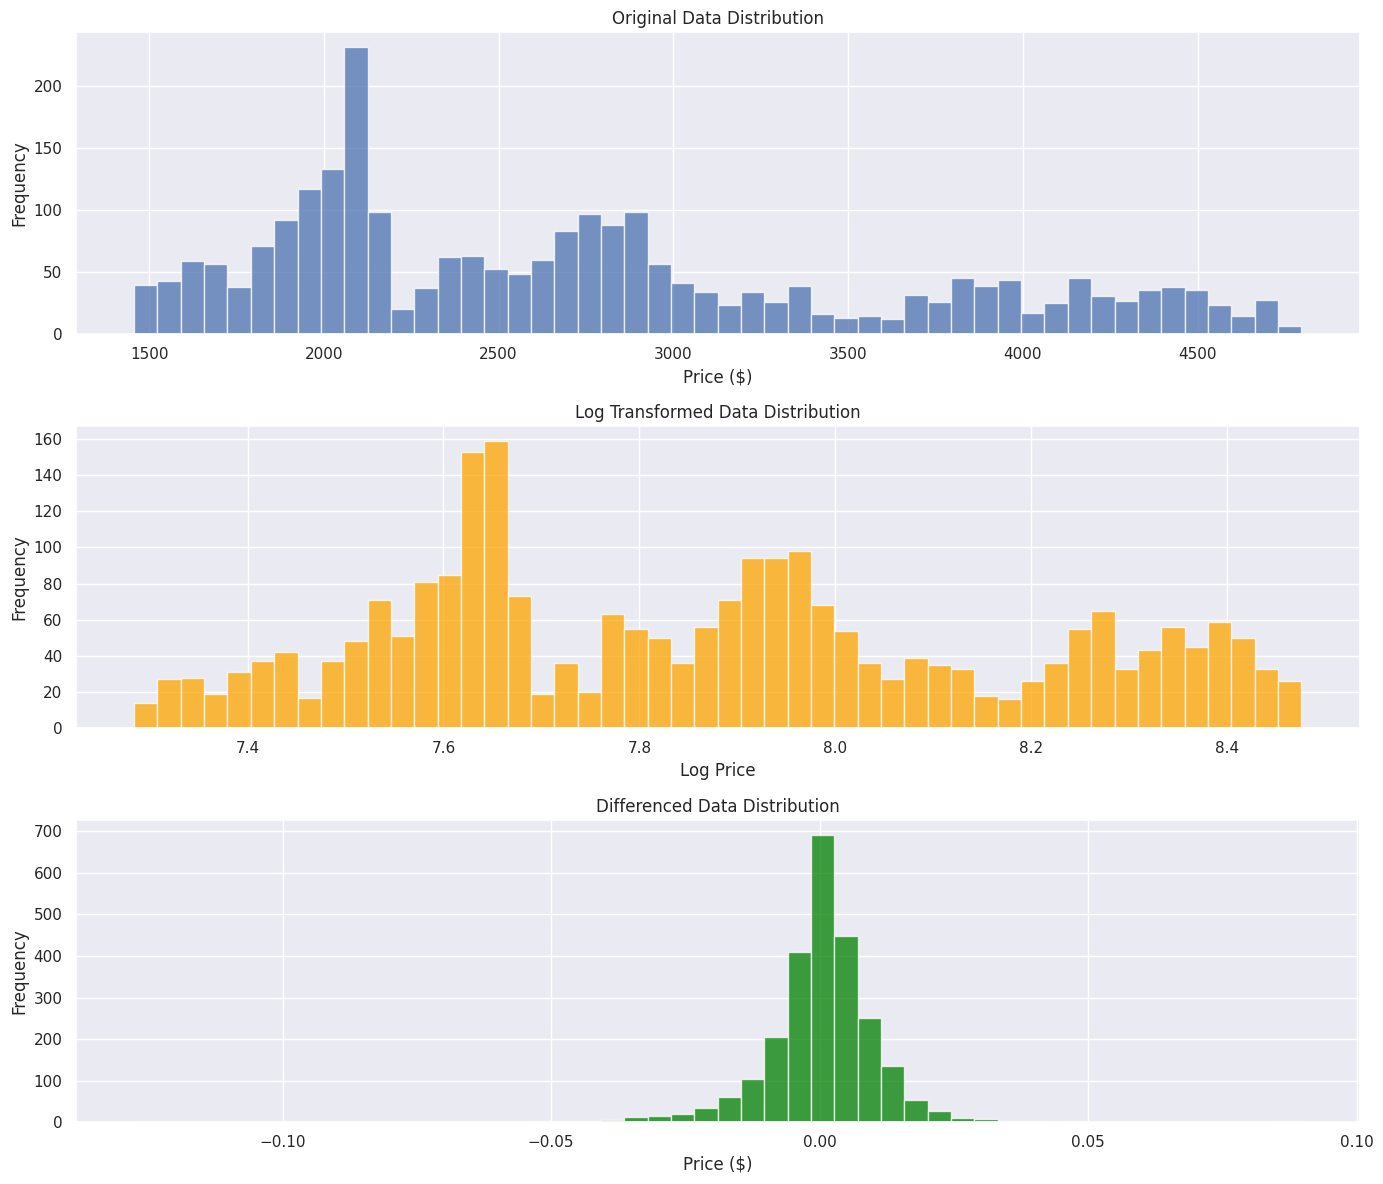

<Figure size 1400x700 with 0 Axes>

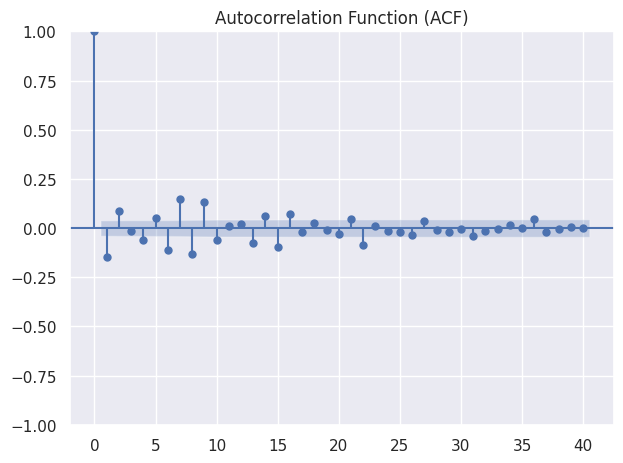

<Figure size 1400x700 with 0 Axes>

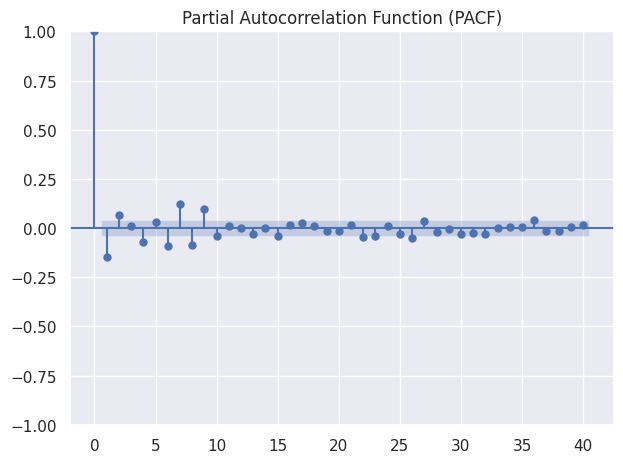

Interpretation of ACF and PACF plots:
1. ACFL Shows coorelation between a time series and its lags.
2. PACF: Shows direct coorelation between a time series and its lags after removing effects of intermediate lags.

Based on these plots, we can determine:
- If ACF tails off gradually and PACF cuts off after lag p, an AR(p) model may be appropriate.
- If ACF cutrs off after lag q and PACF tails off graudally, an MA (q) model may be appropriate.
- If both ACF and PACF tail off gradually, an ARMA model may be appropriate.


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Select the closing price as our primary time series for analysis and convert to Series
ts_data = sp500['Close'].squeeze()
ts_data.name = 'S&P 500 Close' # Explicitly set the Series name to a string


#stationary series
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, title):
    """
    Test for stationarity using the Dickey-Fuller test and plot the time series.

    Parameters:
    timeseries (pd.Series): The time series data.
    title (str): The title for the plot and test results.
    """
    # Plot the time series
    plt.figure(figsize=(14, 7))
    # Remove the explicit label from the plot
    plt.plot(timeseries)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Value')
    # Remove the plt.legend() call
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Dickey-Fuller test
    print(f'Results of Dickey-Fuller test for {title}:')
    dftest = adfuller(timeseries.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput[f'Critical Value ({key})'] = value
    print(dfoutput)

    # Test results for Dickey-Fuller test
    if dftest[1] <= 0.05:
        print('The series is stationary')
    else:
        print('The series is non-stationary')

# test stationary on og time series
test_stationarity(ts_data, 'Original S&P 500 Closing Prices')

#log transformation and convert to Series
ts_log = np.log(ts_data).squeeze()
ts_log.name = 'Log S&P 500 Close' # Explicitly set the Series name to a string


test_stationarity(ts_log, 'Log Transformed S&P 500 Closing Prices')

#first order differencing and convert to Series
ts_log_diff = ts_log.diff().dropna().squeeze()
ts_log_diff.name = 'Differenced Log S&P 500 Close' # Explicitly set the Series name to a string


test_stationarity(ts_log_diff, 'Differenced Log Transformed S&P 500 Closing Prices')

#verify final data
print("Final Transformed data (first 5 values): ")
print(ts_log_diff.head())

#histograms for comparison
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

#og data distribution
axes[0].hist(ts_data, bins=50, alpha=0.75)
axes[0].set_title('Original Data Distribution')
axes[0].set_xlabel('Price ($)')
axes[0].set_ylabel('Frequency')

# Log transformed data distribution
axes[1].hist(ts_log, bins=50, alpha=0.75, color='orange')
axes[1].set_title('Log Transformed Data Distribution')
axes[1].set_xlabel('Log Price')
axes[1].set_ylabel('Frequency')

axes[2].hist(ts_log_diff, bins=50, alpha=0.75, color= 'green')
axes[2].set_title('Differenced Data Distribution')
axes[2].set_xlabel('Price ($)')
axes[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

stationary_series = ts_log_diff.dropna()

#plot ACF and find it

plt.figure(figsize=(14,7))
plot_acf(stationary_series, lags=40, alpha=0.05)
plt.title('Autocorrelation Function (ACF)')
plt.grid(True)
plt.tight_layout()
plt.show()

#plot PACF
plt.figure(figsize=(14,7))
plot_pacf(stationary_series, lags=40, alpha=0.05)
plt.title('Partial Autocorrelation Function (PACF)')
plt.grid(True)
plt.tight_layout()
plt.show()

#interpret

print("Interpretation of ACF and PACF plots:")
print("1. ACFL Shows coorelation between a time series and its lags.")
print("2. PACF: Shows direct coorelation between a time series and its lags after removing effects of intermediate lags." )
print("")
print("Based on these plots, we can determine:")
print("- If ACF tails off gradually and PACF cuts off after lag p, an AR(p) model may be appropriate.")
print("- If ACF cutrs off after lag q and PACF tails off graudally, an MA (q) model may be appropriate.")
print("- If both ACF and PACF tail off gradually, an ARMA model may be appropriate.")

### Step 6: Time Series Modeling
Finally, let's build and evaluate time series models based on our analysis.

[*********************100%***********************]  1 of 1 completed

ARIMA(1, 0, 0) Model Summary:
AIC:  1452.9540
BIC:  1461.2914


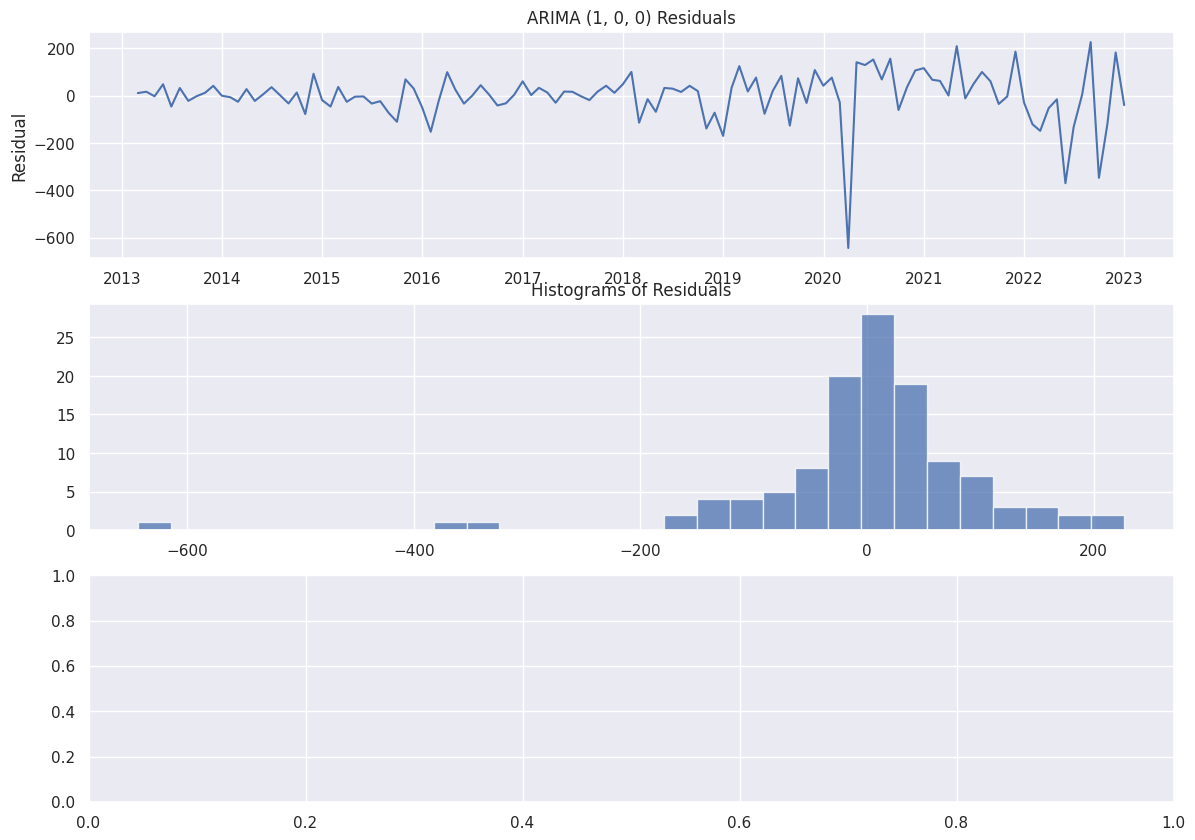

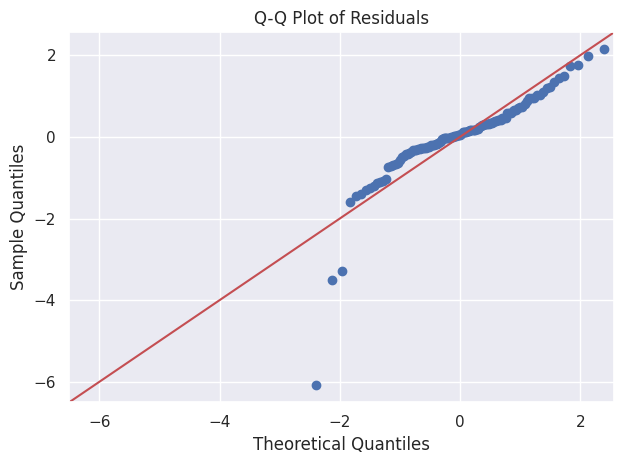

ARIMA(0, 0, 1) Model Summary:
AIC:  1452.6885
BIC:  1461.0259


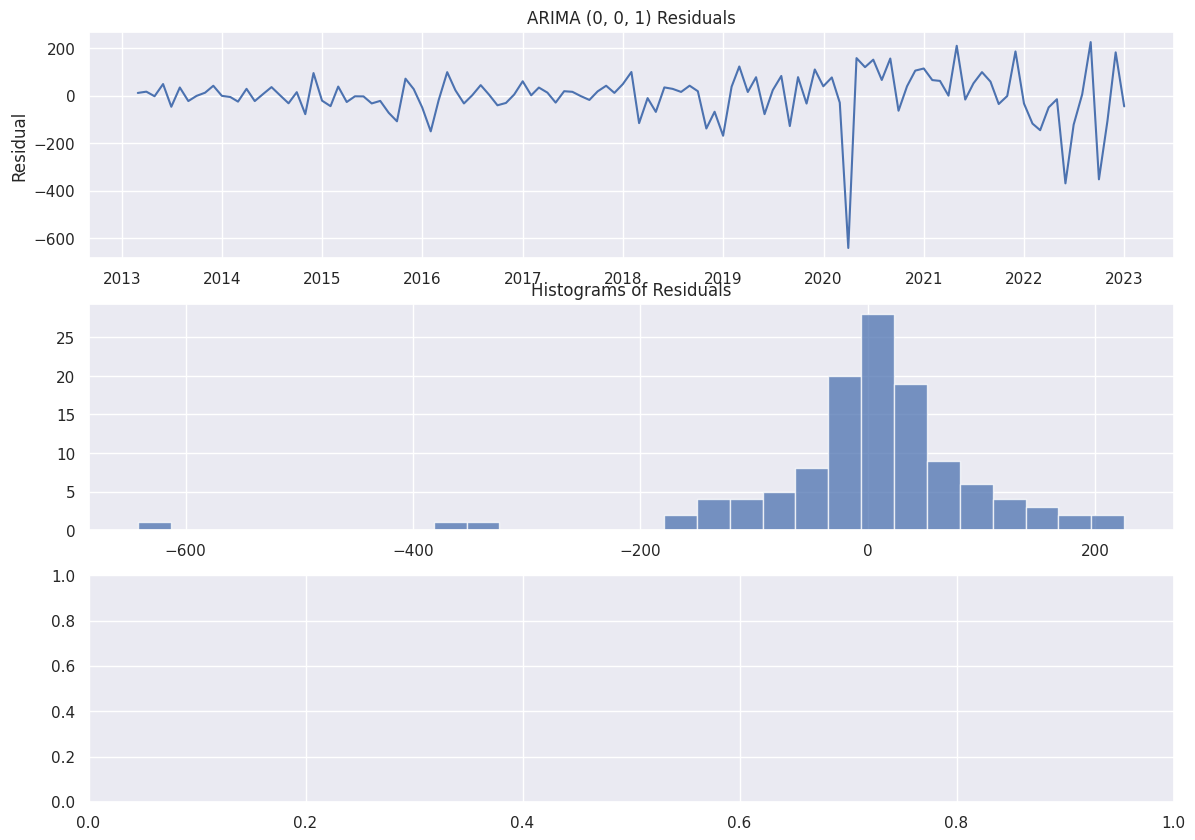

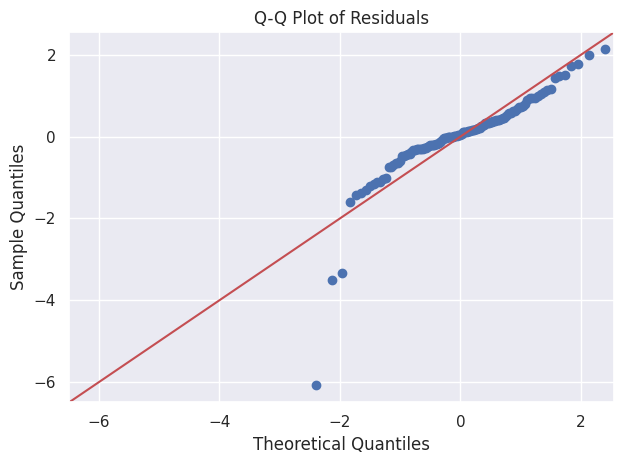

ARIMA(1, 1, 1) Model Summary:
AIC:  1446.3772
BIC:  1454.6893


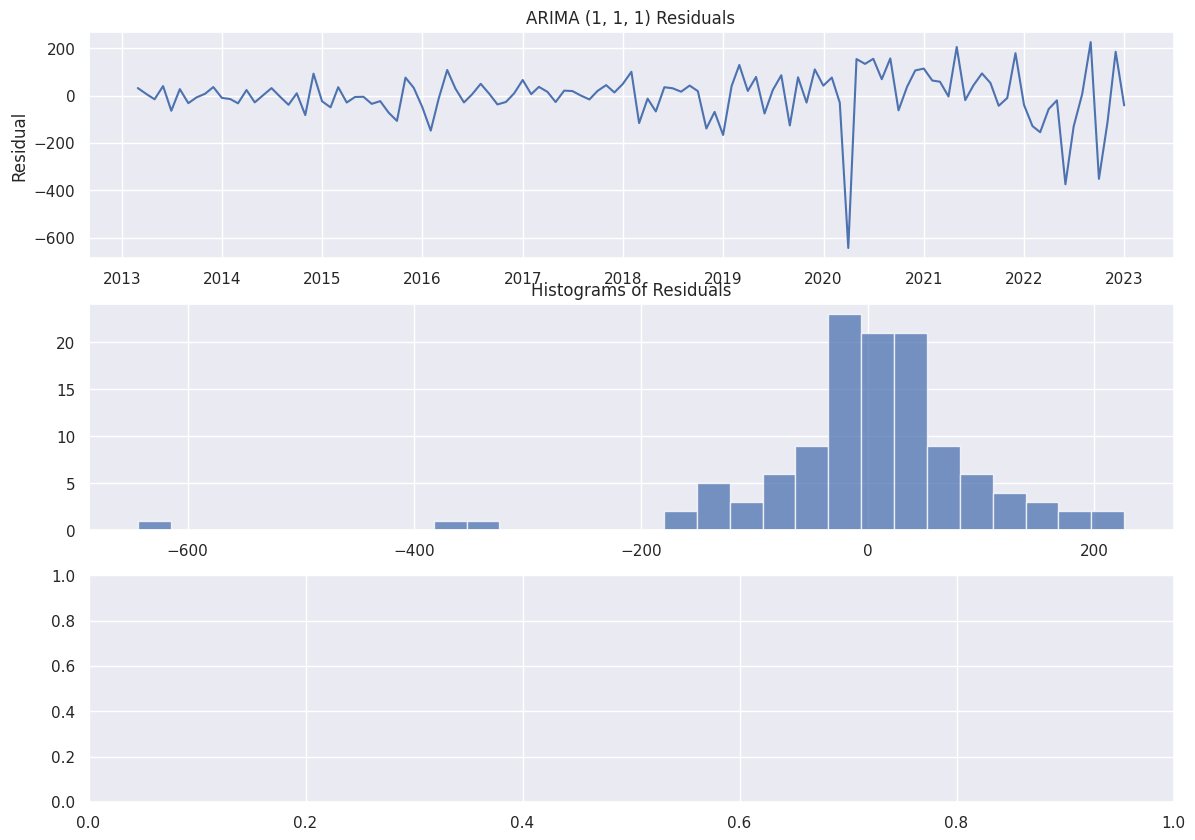

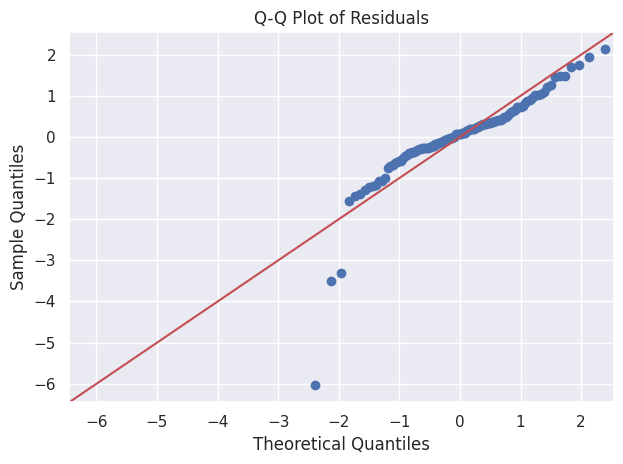


Comparison Table by AIC and BIC:
                       AIC          BIC
AR (1)         1452.954032  1461.291402
MA (1)         1452.688507  1461.025878
ARIMA (1,1,1)  1446.377220  1454.689274

Best Model based on AIC: ARIMA (1,1,1)


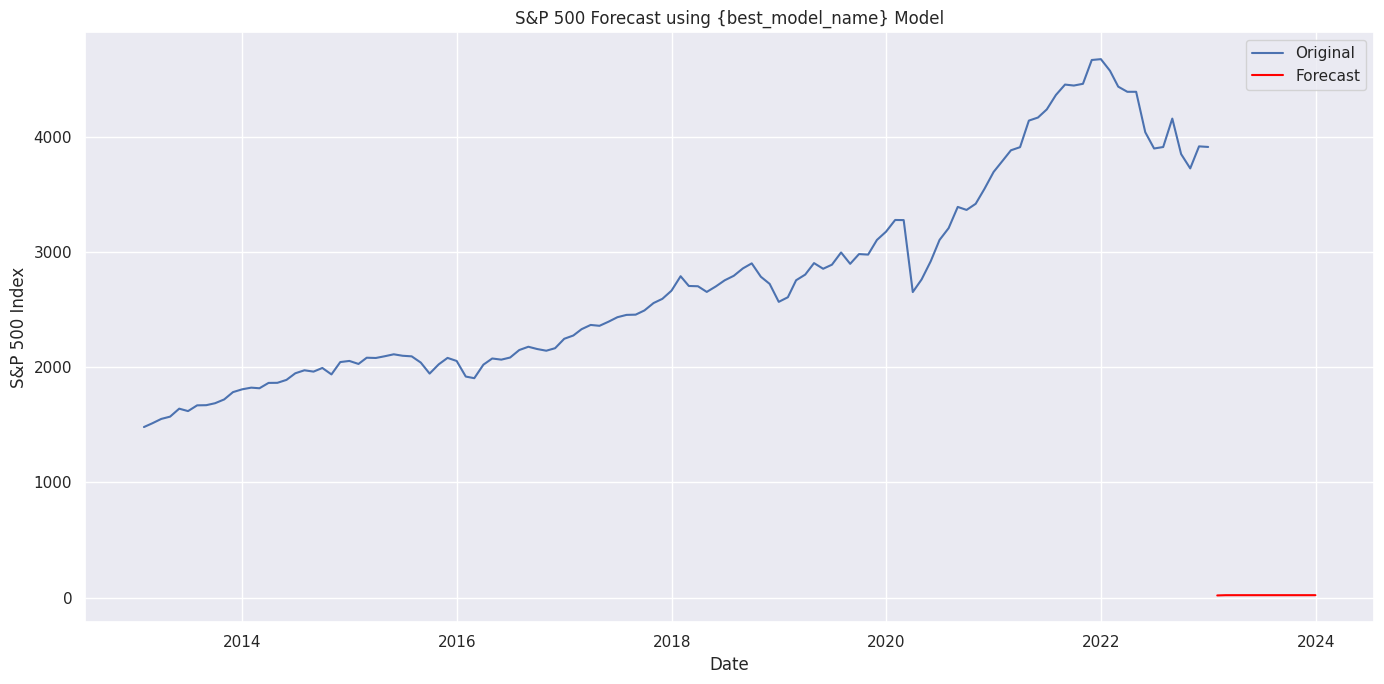

Mean Absolute Error (MAE): 59.6035
Root Mean Squared Error (RMSE): 95.6694
Mean Absolute Percentage Error (MAPE): 764.1585%


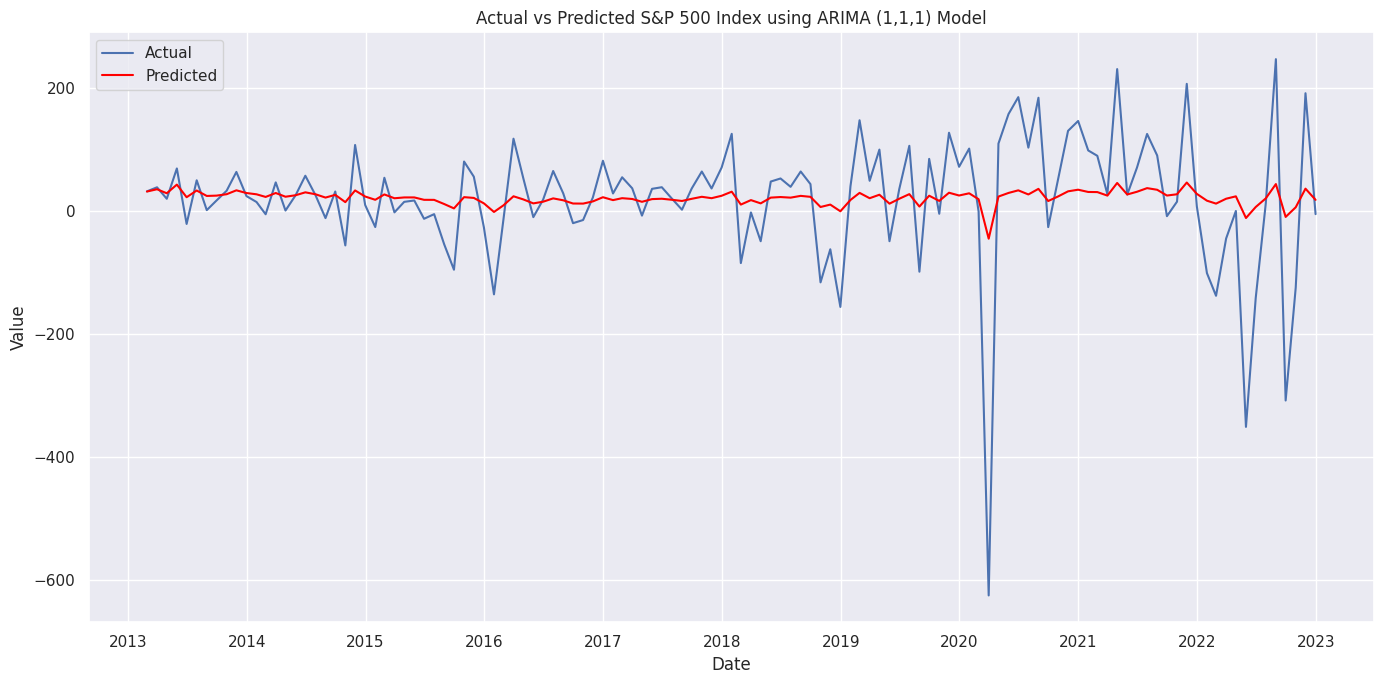

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import yfinance as yf
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set plotting style
sns.set_theme()

# Download S&P 500 data for the last 10 years
sp500 = yf.download('^GSPC', start='2013-01-01', end='2022-12-31')

# Select the closing price as our primary time series for analysis
ts_data = sp500['Close']

#resample data to monthly freq

monthly_ts = ts_data.resample('M').mean()

#evaluate ARIMA models

def fit_arima_model(series, order, title):

  #fit arima model and evaluate
  try:
    model = ARIMA(series, order=order)
    model_fit = model.fit()

    #print model summary
    print(f"ARIMA{order} Model Summary:")
    print(f"AIC: {model_fit.aic: .4f}")
    print(f"BIC: {model_fit.bic: .4f}")

    #plot residuals
    plt.figure(figsize=(14,10))

    #residuals over time
    plt.subplot(311)
    plt.plot(model_fit.resid)
    plt.title(f'ARIMA {order} Residuals')
    plt.ylabel('Residual')
    plt.grid(True)


    #histogram of residuals
    plt.subplot(312)
    plt.hist(model_fit.resid, bins=30, alpha=0.75)
    plt.title('Histograms of Residuals')
    plt.grid(True)

    import statsmodels.api as sm
    #Q-Q plot
    plt.subplot(313)
    sm.graphics.qqplot(model_fit.resid, line='45', fit=True)
    plt.title('Q-Q Plot of Residuals')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    #fitted model
    return model_fit

  except Exception as e:
    print(f"Error fitting ARIMA{order} model: {e}")
    return None

#monthly data
monthly_stationary = monthly_ts.diff().dropna()

#ar model
ar_model = fit_arima_model(monthly_stationary, order=(1,0,0), title='AR (1)')

#ma model
ma_model = fit_arima_model(monthly_stationary, order=(0,0,1), title='MA (1)')

#ARIMA model

arima_model = fit_arima_model(monthly_stationary, order=(1,1,1), title='ARIMA (1,1,1)')

#compare by AIC + BIC
models = {
    'AR (1)': ar_model,
    'MA (1)': ma_model,
    'ARIMA (1,1,1)': arima_model
}

#comparison table

comparison_table = pd.DataFrame({
    'AIC': {name: model.aic if model is not None else np.nan for name, model in models.items()},
    'BIC': {name: model.bic if model is not None else np.nan for name, model in models.items()}
})

print("\nComparison Table by AIC and BIC:")
print(comparison_table)

#find best model

best_model_name = comparison_table['AIC'].idxmin()
print(f"\nBest Model based on AIC: {best_model_name}")

#get best model
best_model = models[best_model_name]

#forecasting

forecast_steps = 12
forecast = best_model.forecast(steps=forecast_steps)

#data ranghe for forecast

last_date = monthly_ts.index[-1]
forecast_index = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=forecast_steps, freq='M')


#plot og series and forecast

plt.figure(figsize=(14,7))
plt.plot(monthly_ts, label='Original')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.title('S&P 500 Forecast using {best_model_name} Model')
plt.xlabel('Date')
plt.ylabel('S&P 500 Index')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#in sample forecast
in_sample_forecast = best_model.predict(start=1, end=len(monthly_stationary))

#model accuracy
actual = monthly_stationary.squeeze()  # Convert actual to a Series
predicted = in_sample_forecast

from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(actual, predicted) # Define mse here
mape = np.mean(np.abs((actual - predicted) / actual)) * 100
mae = mean_absolute_error(actual, predicted)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")


#plot actual vs predicted
plt.figure(figsize=(14,7))
plt.plot(actual.index, actual, label='Actual')
plt.plot(actual.index, predicted, label='Predicted', color='red') # Corrected forecast_index to actual.index
plt.title(f'Actual vs Predicted S&P 500 Index using {best_model_name} Model')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Part 3: Neural Networks Implementation and Optimization

### Step 1: Load libraries and prepare the datasets

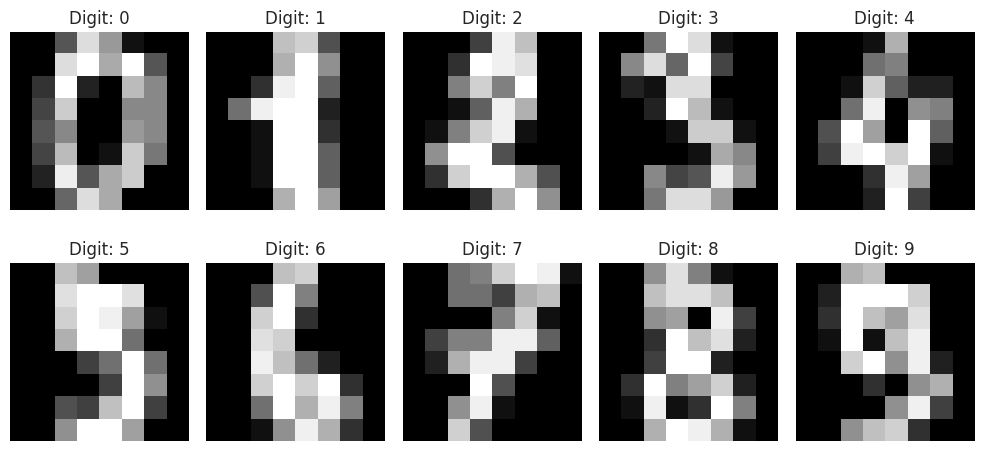

Digits dataset: 1797 samples, 64 features


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits

# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target


# Display sample digits
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(digits.images[i], cmap='gray')
    plt.title(f'Digit: {digits.target[i]}')
    plt.axis('off')
plt.tight_layout()
plt.show()

# Print information about dataset
print(f"Digits dataset: {X_digits.shape[0]} samples, {X_digits.shape[1]} features")

### Step 2: Preprocess data for neural networks

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, classification_report
from sklearn.datasets import load_digits

# For deep learning
import tensorflow as tf
from tensorflow import keras
from keras import layers

# For PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
torch.manual_seed(42)

# Load Digits dataset for classification
digits = load_digits()
X_digits = digits.data
y_digits = digits.target

#split digits data into train and test sets
from sklearn.model_selection import train_test_split

x_digits_train, x_digits_test, y_digits_train, y_digits_test = train_test_split(X_digits, y_digits, test_size=0.2, random_state=42)

# convert digits data to Pytorch Tensors
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_digits_train = torch.tensor(scaler.fit_transform(x_digits_train), dtype=torch.float32).view(-1, 64)
x_digits_test = torch.tensor(scaler.transform(x_digits_test), dtype=torch.float32).view(-1, 64)
y_digits_train = torch.tensor(y_digits_train, dtype=torch.long)
y_digits_test = torch.tensor(y_digits_test, dtype=torch.long)

print("Data processing complete.")

Data processing complete.


In [ ]:
# Build a simple Sequential model using TensorFlow/Keras
model = keras.Sequential([
    # Define the input layer explicitly
    keras.Input(shape=(64,)),
    # Flatten the input data (64 features)
    layers.Flatten(),
    # Add a dense layer with 128 neurons and ReLU activation
    layers.Dense(128, activation='relu'),
    # Add a dense output layer with 10 neurons (for 10 digits) and softmax activation
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,610 (37.54 KB)

 Trainable params: 9,610 (37.54 KB)

 Non-trainable params: 0 (0.00 B)

### Step 3: Build a basic MLP for digits classification using TensorFlow/Keras

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.3673 - loss: 2.0617 - val_accuracy: 0.8833 - val_loss: 0.6984
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9185 - loss: 0.5410 - val_accuracy: 0.9361 - val_loss: 0.2605
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9575 - loss: 0.2167 - val_accuracy: 0.9583 - val_loss: 0.1697
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9718 - loss: 0.1273 - val_accuracy: 0.9694 - val_loss: 0.1321
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9861 - loss: 0.0855 - val_accuracy: 0.9694 - val_loss: 0.1131
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9925 - loss: 0.0604 - val_accuracy: 0.9694 - val_loss: 0.1023
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9962 - loss: 0.0444 - val_accuracy: 0.9694 - val_loss: 0.0955
Epoch 8/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9976 - loss: 0.0336 - val_accuracy: 0.9722 - val_loss:

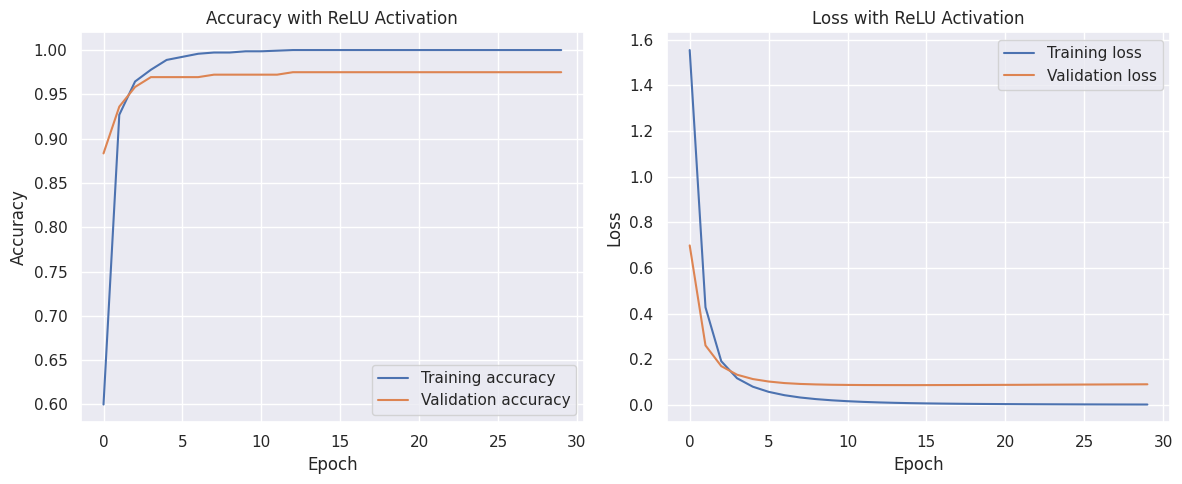

In [ ]:
# build a simple MLP model for digit classification

def build_digits_mlp(activation='relu'):
    model = keras.Sequential([
        keras.Input(shape=(64,)),
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model # Corrected indentation

simrans_model_relu = build_digits_mlp(activation='relu') # Call the function to create the model

history_digits_relu = simrans_model_relu.fit(
    x_digits_train, y_digits_train,
    epochs= 30, # Added comma
    batch_size= 32, # Added comma
    validation_data=(x_digits_test, y_digits_test),
    verbose=1
)

#evaluate
simrans_model_relu_loss, simrans_model_relu_accuracy = simrans_model_relu.evaluate(x_digits_test, y_digits_test, verbose=0)
print(f"Test accuracy with ReLU: {simrans_model_relu_accuracy:.4f}") # Corrected variable name and formatting

#plot
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_digits_relu.history['accuracy'], label='Training accuracy')
plt.plot(history_digits_relu.history['val_accuracy'], label='Validation accuracy')
plt.title('Accuracy with ReLU Activation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_digits_relu.history['loss'], label='Training loss')
plt.plot(history_digits_relu.history['val_loss'], label='Validation loss')
plt.title('Loss with ReLU Activation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Define the PyTorch model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

# Hyperparameters
input_size = 64
hidden_size1 = 128
hidden_size2 = 64
num_classes = 10
num_epochs = 30
batch_size = 32
learning_rate = 0.001

# Create the PyTorch DataLoader
train_dataset = TensorDataset(x_digits_train, y_digits_train)
test_dataset = TensorDataset(x_digits_test, y_digits_test)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model
model_pytorch = MLP(input_size, hidden_size1, hidden_size2, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pytorch.parameters(), lr=learning_rate)

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Forward pass
        outputs = model_pytorch(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print (f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')

# Test the model
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model_pytorch(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the PyTorch model on the {total} test images: {100 * correct / total:.2f} %')

Accuracy of the PyTorch model on the 360 test images: 97.22 %


### Step 4: Implement the digits classification model in PyTorch

Epoch [1/30], Loss: 1.7387, Test Loss: 0.9606, Test Acc: 0.8306
Epoch [2/30], Loss: 0.5387, Test Loss: 0.2960, Test Acc: 0.9250
Epoch [3/30], Loss: 0.2067, Test Loss: 0.1896, Test Acc: 0.9583
Epoch [4/30], Loss: 0.1225, Test Loss: 0.1409, Test Acc: 0.9639
Epoch [5/30], Loss: 0.0834, Test Loss: 0.1202, Test Acc: 0.9694
Epoch [6/30], Loss: 0.0572, Test Loss: 0.1140, Test Acc: 0.9694
Epoch [7/30], Loss: 0.0436, Test Loss: 0.1047, Test Acc: 0.9722
Epoch [8/30], Loss: 0.0322, Test Loss: 0.1020, Test Acc: 0.9722
Epoch [9/30], Loss: 0.0244, Test Loss: 0.0982, Test Acc: 0.9750
Epoch [10/30], Loss: 0.0186, Test Loss: 0.0982, Test Acc: 0.9722
Epoch [11/30], Loss: 0.0151, Test Loss: 0.0997, Test Acc: 0.9750
Epoch [12/30], Loss: 0.0120, Test Loss: 0.0991, Test Acc: 0.9694
Epoch [13/30], Loss: 0.0096, Test Loss: 0.0990, Test Acc: 0.9750
Epoch [14/30], Loss: 0.0080, Test Loss: 0.1001, Test Acc: 0.9722
Epoch [15/30], Loss: 0.0068, Test Loss: 0.1000, Test Acc: 0.9722
Epoch [16/30], Loss: 0.0058, Test 

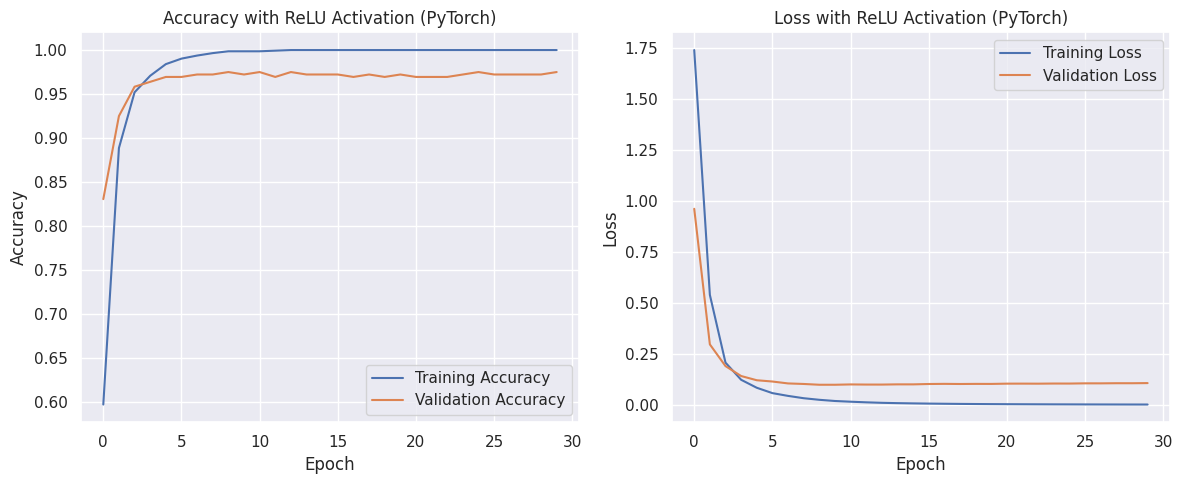


Final Test Accuracy with ReLU: 0.9750


In [ ]:
# define a PyTorch MLP model for digits classification

class simrans_model(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, num_classes):
        super(simrans_model, self).__init__()

        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.activation1 = nn.ReLU() # Use nn.ReLU for activation
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.activation2 = nn.ReLU() # Use nn.ReLU for activation
        self.fc3 = nn.Linear(hidden_size2, num_classes) # Use num_classes for output size

    def forward(self, x):
       x = self.activation1(self.fc1(x))
       x = self.activation2(self.fc2(x))
       x = self.fc3(x)
       return x

#create model with ReLU activation

input_size = 64 # Define input_size
hidden_size1 = 128 # Define hidden_size1
hidden_size2 = 64 # Define hidden_size2
num_classes = 10 # Define num_classes

pytorch_simrans_model = simrans_model(
    input_size = input_size,
    hidden_size1 = hidden_size1,
    hidden_size2 = hidden_size2,
    num_classes = num_classes
)
#loss function and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pytorch_simrans_model.parameters(), lr=0.001)

#dataloader for batch training
train_dataset = TensorDataset(x_digits_train, y_digits_train)
train_loader = DataLoader(train_dataset, batch_size=32,shuffle=True)

#training loop
num_epochs = 30
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(num_epochs):
    pytorch_simrans_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = pytorch_simrans_model(batch_x)
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = correct / total

    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)

    #evaluate
    pytorch_simrans_model.eval() # Use .eval() for evaluation mode
    with torch.no_grad():
        test_outputs = pytorch_simrans_model(x_digits_test) # Use x_digits_test
        test_loss = criterion(test_outputs, y_digits_test).item() # Use y_digits_test
        test_losses.append(test_loss)

        _, predicted = torch.max(test_outputs.data, 1)
        test_acc = (predicted == y_digits_test).sum().item() / y_digits_test.size(0)
        test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')


#plot training and validation accuracy and loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_accs, label='Training Accuracy') # Use train_accs
plt.plot(test_accs, label='Validation Accuracy') # Use test_accs
plt.title('Accuracy with ReLU Activation (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_losses, label='Training Loss') # Use train_losses
plt.plot(test_losses, label='Validation Loss') # Use test_losses
plt.title('Loss with ReLU Activation (PyTorch)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Final evaluation results
print(f"\nFinal Test Accuracy with ReLU: {test_accs[-1]:.4f}") # Use the last test accuracy


Training model with relu activation:
Test accuracy with relu: 0.9750

Training model with tanh activation:
Test accuracy with tanh: 0.9778

Training model with sigmoid activation:
Test accuracy with sigmoid: 0.9722


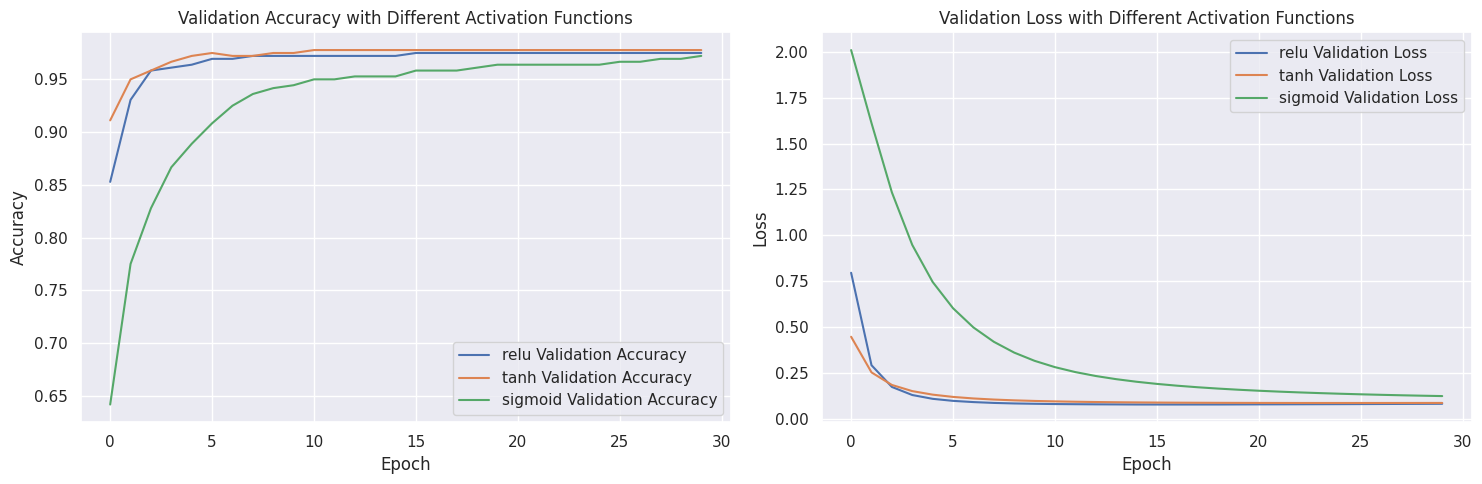


Evaluation Results on Test Set:
relu - Loss: 0.0843, Accuracy: 0.9750
tanh - Loss: 0.0889, Accuracy: 0.9778
sigmoid - Loss: 0.1262, Accuracy: 0.9722


In [ ]:
# Experiment with different activation functions in TensorFlow

def build_digits_mlp_with_activation(activation='relu'):
    """
    Builds a simple MLP model for digit classification with a specified activation function.

    Parameters:
    activation (str): The activation function to use ('relu', 'tanh', 'sigmoid').

    Returns:
    keras.models.Sequential: The compiled Keras model.
    """
    model = keras.Sequential([
        keras.Input(shape=(64,)),
        layers.Dense(128, activation=activation),
        layers.Dense(64, activation=activation),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Train and evaluate models with different activation functions
activation_functions = ['relu', 'tanh', 'sigmoid']
history_dict = {}
evaluation_results = {}

for activation in activation_functions:
    print(f"\nTraining model with {activation} activation:")
    model = build_digits_mlp_with_activation(activation=activation)
    history = model.fit(x_digits_train, y_digits_train, epochs=30, batch_size=32, validation_data=(x_digits_test, y_digits_test), verbose=0)
    history_dict[activation] = history

    loss, accuracy = model.evaluate(x_digits_test, y_digits_test, verbose=0)
    evaluation_results[activation] = {'loss': loss, 'accuracy': accuracy}
    print(f"Test accuracy with {activation}: {accuracy:.4f}")

# Plot training history for each activation function
plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
for activation in activation_functions:
    plt.plot(history_dict[activation].history['val_accuracy'], label=f'{activation} Validation Accuracy')
plt.title('Validation Accuracy with Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
for activation in activation_functions:
    plt.plot(history_dict[activation].history['val_loss'], label=f'{activation} Validation Loss')
plt.title('Validation Loss with Different Activation Functions')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Print evaluation results
print("\nEvaluation Results on Test Set:")
for activation, results in evaluation_results.items():
    print(f"{activation} - Loss: {results['loss']:.4f}, Accuracy: {results['accuracy']:.4f}")

### Step 5: Experiment with different activation functions (TensorFlow)

Test accuracy with ReLU: 0.9750
Test accuracy with tanh: 0.9778
Test accuracy with sigmoid: 0.9722


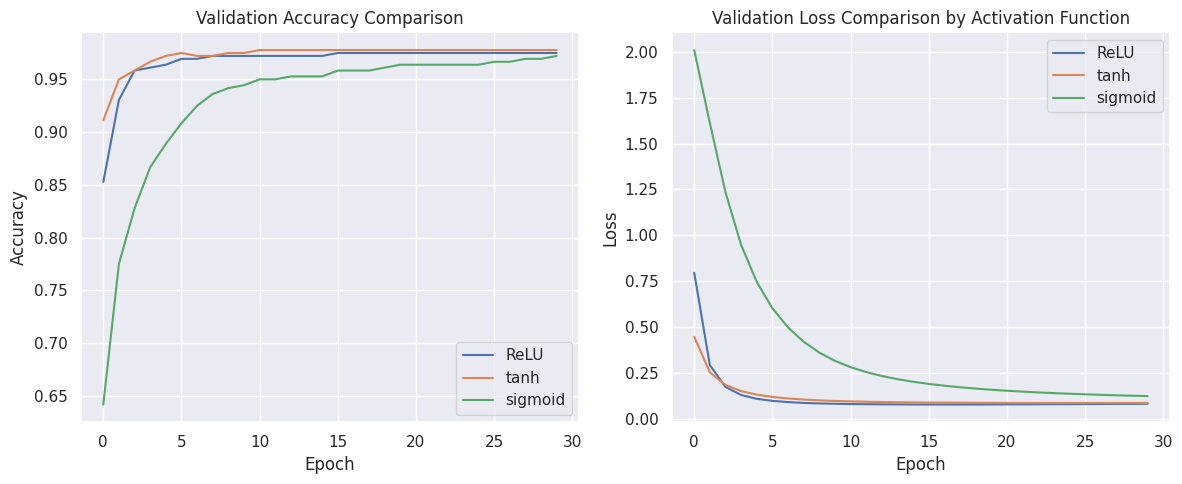

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


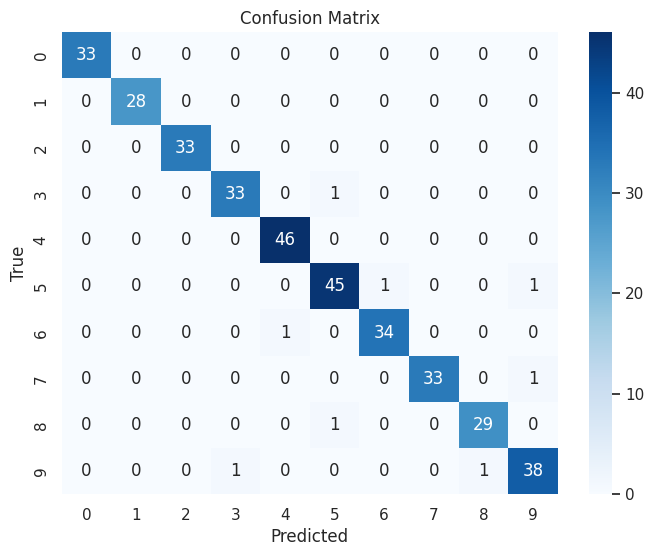

In [ ]:
#create and train model with tanh activation

digits_relu_accuracy = evaluation_results['relu']['accuracy']
digits_tanh_accuracy = evaluation_results['tanh']['accuracy']
digits_sigmoid_accuracy = evaluation_results['sigmoid']['accuracy']


print(f"Test accuracy with ReLU: {digits_relu_accuracy:.4f}")
print(f"Test accuracy with tanh: {digits_tanh_accuracy:.4f}")
print(f"Test accuracy with sigmoid: {digits_sigmoid_accuracy:.4f}")

#compare validation curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history_dict['relu'].history['val_accuracy'], label='ReLU')
plt.plot(history_dict['tanh'].history['val_accuracy'], label='tanh')
plt.plot(history_dict['sigmoid'].history['val_accuracy'], label='sigmoid')

plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_dict['relu'].history['val_loss'], label='ReLU')
plt.plot(history_dict['tanh'].history['val_loss'], label='tanh')
plt.plot(history_dict['sigmoid'].history['val_loss'], label='sigmoid')
plt.title('Validation Loss Comparison by Activation Function')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()


#confusion matrix
model_tanh = build_digits_mlp_with_activation(activation='tanh')
model_tanh.set_weights(history_dict['tanh'].model.get_weights())

y_pred_digits = np.argmax(model_tanh.predict(x_digits_test), axis=1)
cm = confusion_matrix(y_digits_test, y_pred_digits)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()